# Air Pollution by Politics

## Imports & Installs

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import (
    r2_score, mean_squared_error, explained_variance_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.signal import argrelextrema
from kneed import KneeLocator

sys.path.append('../etc')
from refs import state_abbreviation_dict

# Optional (only if you truly need them at runtime)
!pip install kneed
!pip install -q xlrd openpyxl


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Loads

Since the `data` folder is approximately **14 GB**, it has been uploaded to a **shared Google Drive folder**.
To access and use this data in this notebook, follow these steps:

---

### 1. Upload this notebook to **Google Colab**
- Open [Google Colab](https://colab.research.google.com/).
- Click on **File → Upload notebook** and select this notebook.

### 2. Mount your Google Drive
Insert and run the following code in a new Colab cell:

```python
from google.colab import drive
drive.mount('/content/drive')
```
- This will prompt you to authorize access to your Google Drive.

### 3. Create a Shortcut of the `data` Folder in Your Google Drive
- Open the shared Google Drive link.
- **Right-click** the `data` folder → **Add shortcut to Drive**.
- Choose a location inside your **MyDrive** (e.g., directly under "MyDrive" or inside a project folder).

### 4. Update the File Paths in the Notebook
When reading the data files, adjust the paths in your code to point to your shortcut location.
For example:

```python
import pandas as pd

# Example
presidential_data = pd.read_csv('/content/drive/MyDrive/your_folder_name/data/election/relevant/usa/1976-2020-president.csv')
```

Replace `your_folder_name` with the actual folder name where you added the shortcut.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# presidential_data = pd.read_csv('/content/drive/MyDrive/School/data/election/relevant/usa/1976-2020-president.csv')
# senate_data = pd.read_csv('/content/drive/MyDrive/School/data/election/relevant/usa/1976-2020-senate.csv')
# house_data = pd.read_csv('/content/drive/MyDrive/School/data/election/relevant/usa/1976-2022-house.csv')
# house_data['party_simplified'] = house_data['party'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else 'OTHER')
#
# state_emissions_data = pd.read_excel(
#     "/content/drive/MyDrive/School/data/co2_emissions/relevant/1970-2022-state_emissions.xlsx",
#     engine="openpyxl",
#     skiprows=4
# )
#
# state_population_size_data = pd.read_csv('/content/drive/MyDrive/School/data/general_state_data/population_data.csv')
# state_population_size_data.rename(columns={'AK': 'state', '1950': 'year', '135000': 'population'}, inplace=True)
# state_land_size_data = pd.read_csv('/content/drive/MyDrive/School/data/general_state_data/state_sizes.csv')

In [4]:
presidential_data = pd.read_csv('../data/election/relevant/usa/1976-2020-president.csv')
senate_data = pd.read_csv('../data/election/relevant/usa/1976-2020-senate.csv')
house_data = pd.read_csv('../data/election/relevant/usa/1976-2022-house.csv')
house_data['party_simplified'] = house_data['party'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else 'OTHER')

state_emissions_data = pd.read_excel(
    "../data/co2_emissions/relevant/1970-2022-state_emissions.xlsx",
    engine="openpyxl",
    skiprows=4
)

state_population_size_data = pd.read_csv('../data/general_state_data/population_data.csv')
state_population_size_data.rename(columns={'AK': 'state', '1950': 'year', '135000': 'population'}, inplace=True)
state_land_size_data = pd.read_csv('../data/general_state_data/state_sizes.csv')

##  Analysis Per Category

### Election Analysis

This code calculates a political score for each U.S. state based on presidential, House, and Senate election data. It processes the election data for each year, calculates political scores by considering factors like vote percentage, longest streak of party wins, and the party of the most recent winner. It then combines these scores using weighted averages for each state and year. The final political scores are scaled and adjusted using the `MinMaxScaler`, and the scores are returned in a DataFrame, where each row represents a state’s political score for a specific year. This method provides insights into state-level political trends over time.

In [5]:
def calculate_scores_by_year(presidential_data, house_data, senate_data):
    years = sorted(presidential_data['year'].unique())
    all_scores = []

    for year in years:
        pres_results = calculate_political_scores(presidential_data, year)
        house_results = calculate_political_scores(house_data, year)
        sen_results = calculate_political_scores(senate_data, year)
        final_political_score = merge_and_average_scores(house_results, sen_results, pres_results, year)
        all_scores.append(final_political_score)

    return pd.concat(all_scores).reset_index(drop=True)

def calculate_political_scores(df, year=2020):
    df = df[df['year'] <= year].copy()  # Ensure a full copy is made
    df_filtered = df[df['party_simplified'].isin(['DEMOCRAT', 'REPUBLICAN'])].copy()

    df_filtered.loc[:, 'vote_percent'] = df_filtered['candidatevotes'] / df_filtered['totalvotes'] * 100

    df_winner = df_filtered.loc[df_filtered.groupby(['year', 'state'])['candidatevotes'].idxmax()].copy()

    state_streaks = {}
    for state in df_winner['state'].unique():
        state_data = df_winner[df_winner['state'] == state].sort_values('year')
        current_party = None
        streak = 0
        max_streak = 0
        last_winner = None

        for _, row in state_data.iterrows():
            if row['party_simplified'] == current_party:
                streak += 1
            else:
                current_party = row['party_simplified']
                streak = 1
            max_streak = max(max_streak, streak)
            last_winner = current_party

        state_streaks[state] = {'longest_streak': max_streak, 'last_winner': last_winner}

    df_summary = df_winner.groupby('state').agg(
        total_elections=('year', 'count'),
        avg_vote_percent=('vote_percent', 'mean'),
        last_winner=('party_simplified', 'last'),
        last_vote_percent=('vote_percent', 'last')
    ).reset_index()

    df_summary['longest_streak'] = df_summary['state'].map(lambda x: state_streaks[x]['longest_streak'])
    df_summary['streak_party'] = df_summary['state'].map(lambda x: state_streaks[x]['last_winner'])

    df_summary['party_numeric'] = df_summary['last_winner'].map({'REPUBLICAN': -1, 'DEMOCRAT': 1})

    features = df_summary[['longest_streak', 'avg_vote_percent', 'last_vote_percent']]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_summary.loc[:, ['streak_score', 'avg_vote_score', 'last_vote_score']] = scaler.fit_transform(features)

    df_summary['final_score'] = (df_summary['streak_score'] * 0.4 +
                                 df_summary['avg_vote_score'] * 0.3 +
                                 df_summary['last_vote_score'] * 0.3) * df_summary['party_numeric']
    df_summary['year'] = year
    return df_summary[['state', 'year', 'final_score']]

def merge_and_average_scores(house_results, sen_results, pres_results, year=2020):
    df_combined = house_results.merge(sen_results, on=['state', 'year'], suffixes=('_house', '_sen')) \
                               .merge(pres_results, on=['state', 'year'], suffixes=('', '_pres'))

    df_combined['final_score_avg'] = df_combined[['final_score_house', 'final_score_sen', 'final_score']].mean(axis=1)

    return df_combined[['state', 'year', 'final_score_avg']]

final_political_scores_by_year = calculate_scores_by_year(presidential_data, house_data, senate_data)
final_political_scores_by_year = final_political_scores_by_year.rename(columns={'final_score_avg':'party_affiliation_score'})
final_political_scores_by_year

,state,year,party_affiliation_score
0,ARIZONA,1976,-0.276792
1,CALIFORNIA,1976,0.787895
2,CONNECTICUT,1976,0.701563
3,DELAWARE,1976,0.269130
4,FLORIDA,1976,-0.464138
...,...,...,...
578,VIRGINIA,2020,-0.162847
579,WASHINGTON,2020,0.024978
580,WEST VIRGINIA,2020,-0.181551
581,WISCONSIN,2020,-0.268129


### Emissions Analysis

This code analyzes state-level emissions data by excluding any rows containing "Total" in the state name. It then calculates the average emissions for each state across the available years and identifies the top 10 states with the highest and lowest average emissions. The results are visualized in two separate bar charts: one for the top 10 states with the highest emissions, and another for the top 10 states with the lowest emissions, using red and green colors, respectively. These plots help to easily identify and compare the states based on their average emissions over time.

In [6]:
state_emissions_data

,State,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2017,2018,2019,2020,2021,2022,Percent,Absolute,Percent.1,Absolute.1
0,Alabama,102.717308,98.516403,104.984789,109.618074,108.831948,107.827892,108.123429,111.715385,106.665665,...,108.072106,111.907375,105.831211,97.977476,108.309051,109.291123,0.063999,6.573815,0.009067,0.982072
1,Alaska,11.358988,12.646215,13.435356,12.506009,12.793869,14.545277,15.991448,17.984787,19.530629,...,33.612044,34.392556,34.157534,35.915884,39.706281,41.304340,2.636269,29.945353,0.040247,1.598060
2,Arizona,24.937739,27.031606,30.257542,34.484241,36.772653,38.248535,43.806707,50.528150,49.310167,...,90.006330,93.647656,92.112163,79.678622,82.631087,81.426926,2.265209,56.489187,-0.014573,-1.204162
3,Arkansas,36.238491,35.147374,37.246511,40.904539,39.181082,36.417068,38.914652,41.698087,42.461084,...,63.822742,70.451214,64.778837,54.420762,61.727600,63.182542,0.743520,26.944050,0.023570,1.454942
4,California,294.672829,306.128867,313.001675,329.536275,304.727911,311.714448,327.104137,354.674419,345.358928,...,354.472039,356.680792,356.513198,301.963000,324.079546,326.205361,0.107009,31.532531,0.006560,2.125815
5,Colorado,43.057661,43.628581,47.509428,51.112474,50.519445,51.833807,55.165689,58.339998,58.471686,...,88.166320,89.412318,91.099265,79.264087,84.663258,88.685173,1.059684,45.627512,0.047505,4.021915
6,Connecticut,47.839723,45.901611,47.222932,48.585809,45.433967,41.695952,43.441472,43.059846,43.977977,...,33.707466,37.239556,36.494940,33.652811,36.331574,37.041873,-0.225709,-10.797851,0.019550,0.710299
7,Delaware,16.051567,15.907361,15.991638,17.221577,16.636428,15.518162,16.131819,16.116363,16.162534,...,13.712744,13.932115,13.540875,12.158646,12.659583,12.664988,-0.210981,-3.386579,0.000427,0.005405
8,District of Columbia,13.642245,11.877348,11.306110,11.850583,9.849625,7.890092,7.690561,7.922985,7.450558,...,2.578868,2.851156,2.799149,2.393873,2.581308,2.645821,-0.806057,-10.996424,0.024992,0.064513
9,Florida,104.403707,111.555148,121.728053,132.294566,124.346429,125.987894,134.577618,138.240436,146.157945,...,237.368371,240.946920,232.630532,206.725204,225.411105,231.001254,1.212577,126.597547,0.024800,5.590150


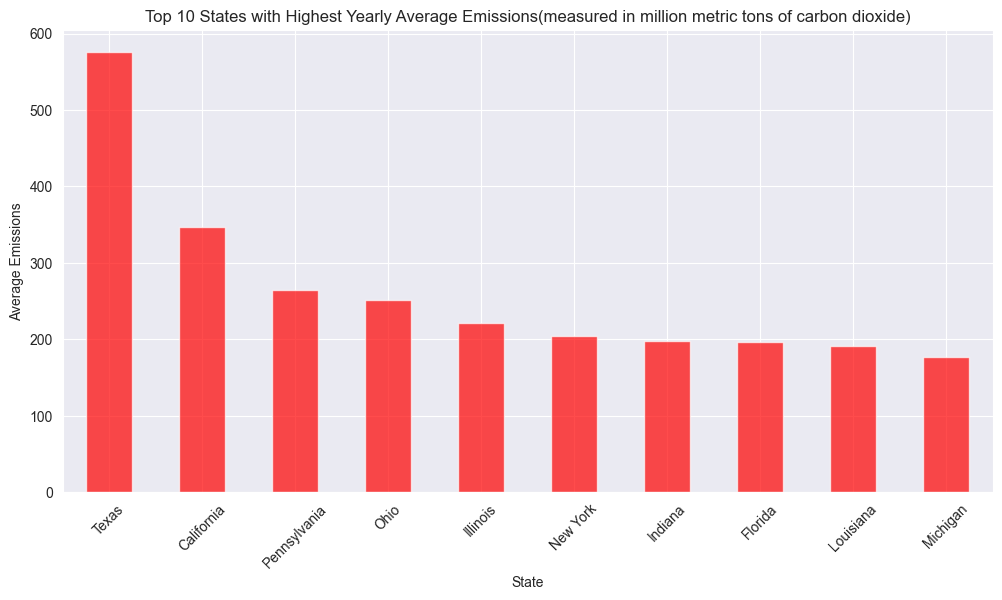

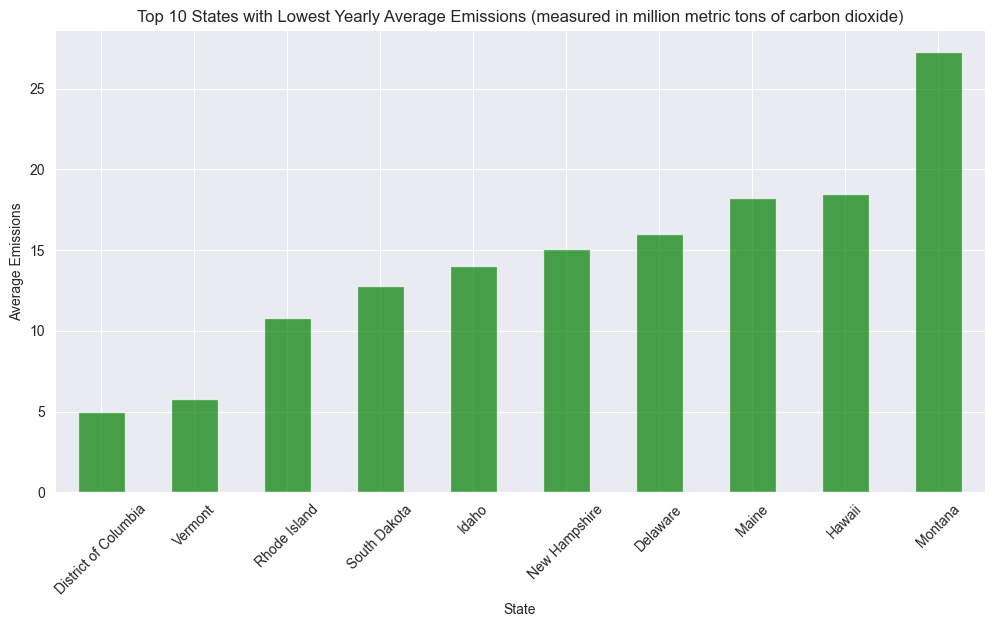

In [7]:
state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Total", case=False, na=False)]
year_columns = [col for col in state_emissions_data.columns if isinstance(col, int)]
top_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nlargest(10)
bottom_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nsmallest(10)

plt.figure(figsize=(12, 6))
top_states.plot(kind='bar', color='red', alpha=0.7)
plt.title("Top 10 States with Highest Yearly Average Emissions(measured in million metric tons of carbon dioxide)")
plt.xlabel("State")
plt.ylabel("Average Emissions")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
bottom_states.plot(kind='bar', color='green', alpha=0.7)
plt.title("Top 10 States with Lowest Yearly Average Emissions (measured in million metric tons of carbon dioxide)")
plt.xlabel("State")
plt.ylabel("Average Emissions")
plt.xticks(rotation=45)
plt.show()

This code analyzes and visualizes emissions data alongside political scores for U.S. states. It first filters out rows containing "Total" in the state name and then identifies the top and bottom 10 states based on their average emissions over time. For each of these states, it detects local minima and maxima in emissions using the `argrelextrema` function. It then plots emissions data over time, marking the local extrema points with blue (minima) and red (maxima) markers, while displaying corresponding political scores at each point. The `plot_emissions_with_extrema` function is used to generate two separate plots: one for the top 10 states with the highest emissions and another for the bottom 10 states with the lowest emissions. Additionally, the `extract_state_name` function extracts the state name from a given directory path. This comprehensive analysis helps in understanding the trends in emissions in relation to political scores over time.

In [8]:
def extract_state_name(base_directory):
    return os.path.basename(base_directory)

In [9]:
def analyze_and_plot_emissions(state_emissions_data, political_scores_data):
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Total", case=False, na=False)]
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].isna()]
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Source:", na=False)]

    year_columns = [col for col in state_emissions_data.columns if isinstance(col, int)]
    top_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nlargest(5).index
    bottom_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nsmallest(5).index

    top_states_data = state_emissions_data[state_emissions_data['State'].isin(top_states)].set_index('State')[year_columns].T
    bottom_states_data = state_emissions_data[state_emissions_data['State'].isin(bottom_states)].set_index('State')[year_columns].T

    def find_local_extrema(data):
        extrema = {}
        for state in data.columns:
            emissions = data[state].values
            years = data.index.values
            local_min_idx = argrelextrema(emissions, np.less)[0]  # Indices of local minima
            local_max_idx = argrelextrema(emissions, np.greater)[0]  # Indices of local maxima
            extrema[state] = {
                "min": [(years[i], emissions[i]) for i in local_min_idx],  # Store (year, emission) pairs for mins
                "max": [(years[i], emissions[i]) for i in local_max_idx]   # Store (year, emission) pairs for max
            }
        return extrema

    top_extrema = find_local_extrema(top_states_data)
    bottom_extrema = find_local_extrema(bottom_states_data)

    def plot_emissions_with_extrema(data, extrema, title, scores_data):
        plt.figure(figsize=(12, 6))

        for state in data.columns:
            plt.plot(data.index, data[state], label=state)

            for x, y in extrema[state]["min"]:
                plt.scatter(x, y, color='blue', marker='v', zorder=5)
                # Convert both state names to uppercase for comparison
                score = scores_data[(scores_data['state'].str.upper() == state.upper()) & (scores_data['year'] == x)]['party_affiliation_score'].values
                if len(score) > 0:
                    # Display the Min label with party affiliation score
                    plt.text(x, y - 0.2, f"Min {score[0]:.2f}", fontsize=9, verticalalignment='bottom', horizontalalignment='center')
            for x, y in extrema[state]["max"]:
                plt.scatter(x, y, color='red', marker='^', zorder=5)
                score = scores_data[(scores_data['state'].str.upper() == state.upper()) & (scores_data['year'] == x)]['party_affiliation_score'].values
                if len(score) > 0:
                    plt.text(x, y + 0.2, f"Max {score[0]:.2f}", fontsize=9, verticalalignment='top', horizontalalignment='center')

        plt.title(title)
        plt.xlabel("Year")
        plt.ylabel("Emissions")
        plt.legend(title="States", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plot_emissions_with_extrema(top_states_data, top_extrema, "Top 5 States with Highest Emissions Over Time", political_scores_data)
    plot_emissions_with_extrema(bottom_states_data, bottom_extrema, "Top 5 States with Lowest Emissions Over Time", political_scores_data)

In [10]:
state_emissions_data

,State,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2017,2018,2019,2020,2021,2022,Percent,Absolute,Percent.1,Absolute.1
0,Alabama,102.717308,98.516403,104.984789,109.618074,108.831948,107.827892,108.123429,111.715385,106.665665,...,108.072106,111.907375,105.831211,97.977476,108.309051,109.291123,0.063999,6.573815,0.009067,0.982072
1,Alaska,11.358988,12.646215,13.435356,12.506009,12.793869,14.545277,15.991448,17.984787,19.530629,...,33.612044,34.392556,34.157534,35.915884,39.706281,41.304340,2.636269,29.945353,0.040247,1.598060
2,Arizona,24.937739,27.031606,30.257542,34.484241,36.772653,38.248535,43.806707,50.528150,49.310167,...,90.006330,93.647656,92.112163,79.678622,82.631087,81.426926,2.265209,56.489187,-0.014573,-1.204162
3,Arkansas,36.238491,35.147374,37.246511,40.904539,39.181082,36.417068,38.914652,41.698087,42.461084,...,63.822742,70.451214,64.778837,54.420762,61.727600,63.182542,0.743520,26.944050,0.023570,1.454942
4,California,294.672829,306.128867,313.001675,329.536275,304.727911,311.714448,327.104137,354.674419,345.358928,...,354.472039,356.680792,356.513198,301.963000,324.079546,326.205361,0.107009,31.532531,0.006560,2.125815
5,Colorado,43.057661,43.628581,47.509428,51.112474,50.519445,51.833807,55.165689,58.339998,58.471686,...,88.166320,89.412318,91.099265,79.264087,84.663258,88.685173,1.059684,45.627512,0.047505,4.021915
6,Connecticut,47.839723,45.901611,47.222932,48.585809,45.433967,41.695952,43.441472,43.059846,43.977977,...,33.707466,37.239556,36.494940,33.652811,36.331574,37.041873,-0.225709,-10.797851,0.019550,0.710299
7,Delaware,16.051567,15.907361,15.991638,17.221577,16.636428,15.518162,16.131819,16.116363,16.162534,...,13.712744,13.932115,13.540875,12.158646,12.659583,12.664988,-0.210981,-3.386579,0.000427,0.005405
8,District of Columbia,13.642245,11.877348,11.306110,11.850583,9.849625,7.890092,7.690561,7.922985,7.450558,...,2.578868,2.851156,2.799149,2.393873,2.581308,2.645821,-0.806057,-10.996424,0.024992,0.064513
9,Florida,104.403707,111.555148,121.728053,132.294566,124.346429,125.987894,134.577618,138.240436,146.157945,...,237.368371,240.946920,232.630532,206.725204,225.411105,231.001254,1.212577,126.597547,0.024800,5.590150


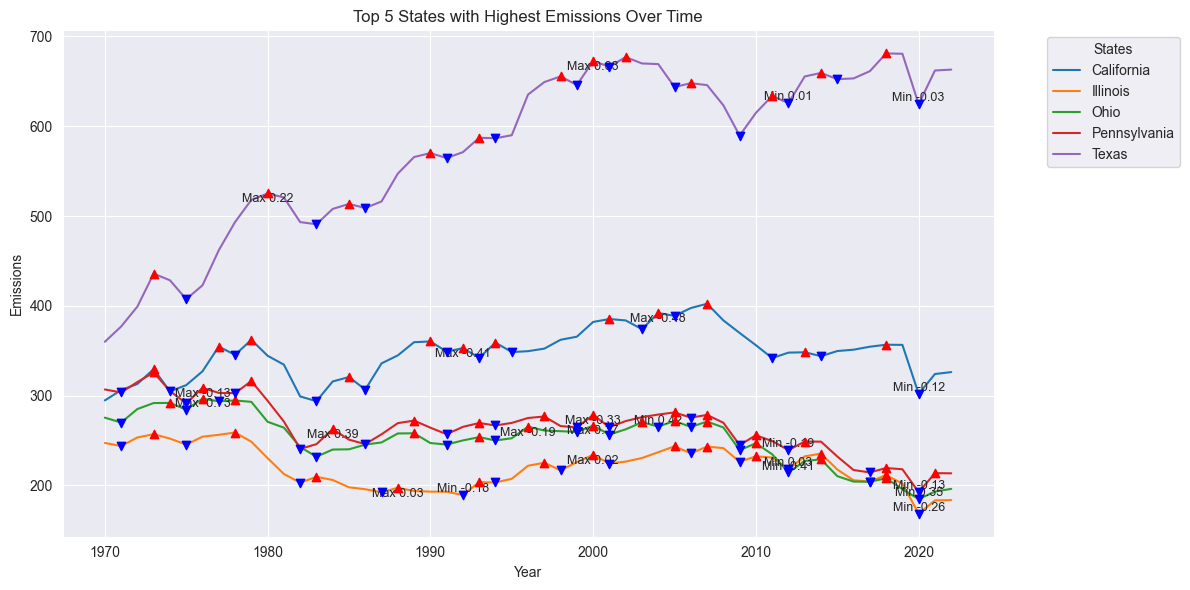

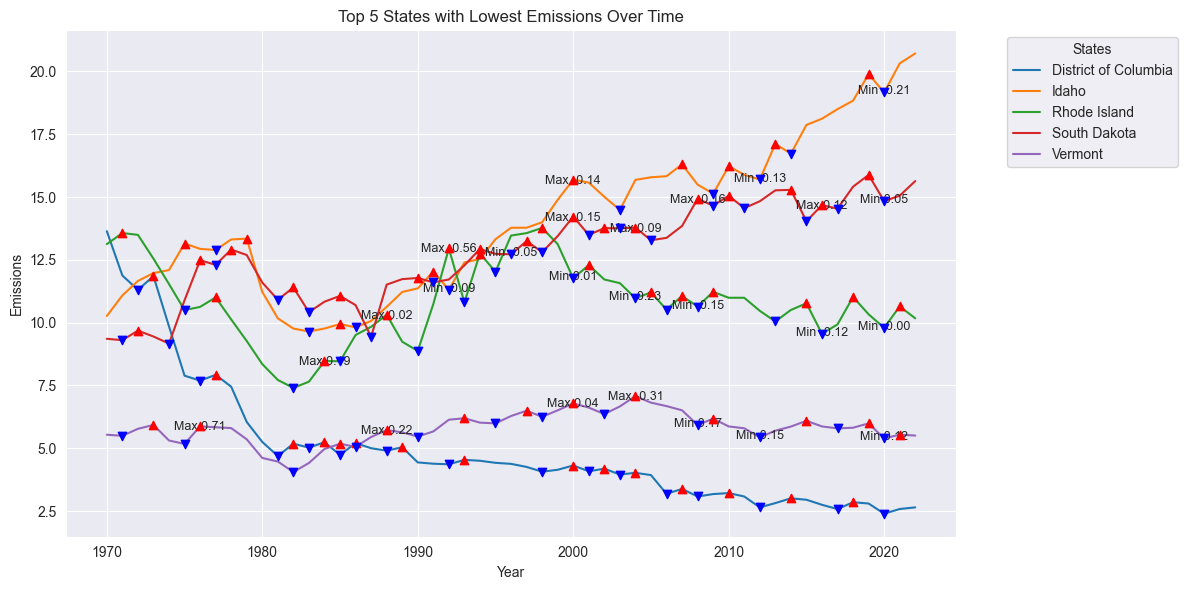

In [11]:
analyze_and_plot_emissions(state_emissions_data, final_political_scores_by_year)

### Demographic and Size Additions

This code performs data transformation and merging to create a comprehensive dataset for analysis. It starts by melting the `state_emissions_data` to reshape it, converting column names to lowercase and standardizing state names using a dictionary (`state_abbreviation_dict`). It then filters the data to include only valid years and merges it with `state_population_size_data` based on state and year. The `state_land_size_data` is also processed and merged to include land size information. Afterward, the political score data (`final_political_scores_by_year`) is integrated into the dataset by standardizing state names and performing another merge. The final result is a merged dataset (`final_merged_dataset`) containing emissions, population size, land size, and political scores for each state and year, ready for further analysis.

In [12]:
state_emissions_melted = state_emissions_data.melt(id_vars=["State"],
                                                   var_name="Year",
                                                   value_name="Emissions")
state_emissions_melted.columns = state_emissions_melted.columns.str.lower()
state_emissions_melted = state_emissions_melted.applymap(lambda x: x.lower() if isinstance(x, str) else x)

state_emissions_melted["state"] = state_emissions_melted["state"].map(state_abbreviation_dict)

state_emissions_melted["year"] = state_emissions_melted["year"].astype(str)
state_emissions_melted = state_emissions_melted.dropna(subset=["year"])  # Remove NaNs
state_emissions_melted = state_emissions_melted[state_emissions_melted["year"].str.isnumeric()]  # Keep only numeric years

state_emissions_melted["year"] = state_emissions_melted["year"].astype(int)
state_population_size_data["year"] = state_population_size_data["year"].astype(int)

merged_population_and_emission_data = state_emissions_melted.merge(state_population_size_data, on=["state", "year"], how="inner")

state_land_size_data = state_land_size_data.rename(columns={"State": "state"})
state_land_size_data["state"] = state_land_size_data["state"].str.lower().map(state_abbreviation_dict)

merged_size_population_emissions_data = merged_population_and_emission_data.merge(state_land_size_data, on="state", how="inner")
merged_size_population_emissions_data = merged_size_population_emissions_data.rename(columns={"Size (Square Miles)": "size"})

final_political_scores_by_year["state"] = final_political_scores_by_year["state"].str.lower().map(state_abbreviation_dict)



all_states = final_political_scores_by_year['state'].unique()
all_years = np.arange(1970, final_political_scores_by_year['year'].max() + 1)
full_index = pd.MultiIndex.from_product([all_states, all_years], names=['state', 'year'])
final_political_scores_full = final_political_scores_by_year.set_index(['state', 'year']).reindex(full_index).reset_index()

imputer = SimpleImputer(strategy='mean')
numeric_cols = final_political_scores_full.select_dtypes(include=[np.number]).columns
final_political_scores_full[numeric_cols] = imputer.fit_transform(final_political_scores_full[numeric_cols])

final_merged_dataset = merged_size_population_emissions_data.merge(
    final_political_scores_full,
    on=["state", "year"],
    how="inner"
)

final_merged_dataset

,state,year,emissions,population,size,party_affiliation_score
0,AL,1970,102.717308,3444354,52420,-0.030073
1,AL,1971,98.516403,3497076,52420,-0.030073
2,AL,1972,104.984789,3539400,52420,-0.030073
3,AL,1973,109.618074,3579780,52420,-0.030073
4,AL,1974,108.831948,3626499,52420,-0.030073
...,...,...,...,...,...,...
2545,WY,2016,61.035090,585243,97813,-0.280461
2546,WY,2017,62.583762,579994,97813,-0.030073
2547,WY,2018,63.639323,579054,97813,-0.030073
2548,WY,2019,58.897673,580116,97813,-0.030073


### Bills Analysis

This code processes environmental bills and votes data across multiple directories to calculate a "Final Score" for each state and year. It begins by loading JSON files for bills and votes, normalizing and merging the data, and calculating the percentage of "yes" votes for each bill. The code identifies climate-related bills by checking for specific environmental terms in the bill description, calculates a weighted climate score based on vote percentages, and sums these scores to get the final score. The code is designed to process files for all states and years in a directory structure, aggregating the results into a final DataFrame. It also measures the execution time and saves the results to a CSV file. The final output provides a dataset of average "Final Scores" by year and state, reflecting the states' environmental legislative activity over time.

In [13]:
def process_bills_and_votes(bill_directory, vote_directory, environmental_terms):
    def load_json_files_from_directory(directory_path):
        data_list = []
        if os.path.exists(directory_path) and os.listdir(directory_path):
            for filename in os.listdir(directory_path):
                if filename.endswith(".json"):
                    with open(os.path.join(directory_path, filename), 'r') as file:
                        data = json.load(file)
                        df = pd.json_normalize(data)
                        data_list.append(df)
            return pd.concat(data_list, ignore_index=True) if data_list else pd.DataFrame()
        return pd.DataFrame()

    bill_df = load_json_files_from_directory(bill_directory)
    if bill_df.empty:
        return 0

    bill_df.columns = [col.split('.')[-1] for col in bill_df.columns]

    vote_df = load_json_files_from_directory(vote_directory)
    if vote_df.empty:
        return 0

    vote_df.columns = [col.split('.')[-1] for col in vote_df.columns]

    merged_df = pd.merge(bill_df, vote_df, on="bill_id", how="outer")
    merged_df = merged_df.drop_duplicates(subset='bill_id', keep='first')
    merged_df['percent_yes'] = merged_df['yea'] / merged_df['total']
    merged_df = merged_df[['percent_yes', 'bill_id', 'title', 'description']].reset_index().drop(columns=['index'])

    merged_df['climate'] = merged_df['description'].apply(lambda x: 1 if any(term.lower() in str(x).lower() for term in environmental_terms) else 0)
    merged_df.fillna(0)

    climate_ratio = merged_df['climate'].sum() / len(merged_df) if len(merged_df) > 0 else 0
    merged_df['weighted_climate'] = climate_ratio * merged_df['percent_yes']
    final_score = merged_df['weighted_climate'].sum()

    return final_score

def process_all_files(base_directory, environmental_terms):
    year = os.path.basename(base_directory).split('-')[0]
    file_dict = {}

    vote_dir = os.path.join(base_directory, 'vote')
    bill_dir = os.path.join(base_directory, 'bill')

    file_dict[year] = process_bills_and_votes(bill_dir, vote_dir, environmental_terms)

    df = pd.DataFrame(list(file_dict.items()), columns=['Year', 'Final_Score'])
    return df

def process_all_states(base_directory, environmental_terms):
    results = []
    for subdir in os.listdir(base_directory):
        subdir_path = os.path.join(base_directory, subdir)
        print(subdir_path)
        if os.path.isdir(subdir_path):
            subdirectory_df = process_all_files(subdir_path, environmental_terms)
            results.append(subdirectory_df)

    state = extract_state_name(base_directory)
    final_df = pd.concat(results, ignore_index=True)
    final_df['State'] = state
    return final_df

def process_all_directories(base_directory, environmental_terms):
    all_results = []
    state_count = 1

    for state_dir in os.listdir(base_directory):
        print(f"{state_count}: Processing state: {state_dir}")
        state_count+=1
        state_dir_path = os.path.join(base_directory, state_dir)

        if os.path.isdir(state_dir_path):
            state_df = process_all_states(state_dir_path, environmental_terms)
            all_results.append(state_df)

    final_df = pd.concat(all_results, ignore_index=True)
    final_df = final_df.sort_values('Year').reset_index().drop(columns=['index'])
    final_df = final_df.groupby(['Year', 'State'])['Final_Score'].mean().reset_index()

    return final_df

def process_all_directories_timed(base_directory, environmental_terms):
    start_time = time.time()

    results_df = process_all_directories(base_directory, environmental_terms)

    end_time = time.time()
    execution_time = end_time - start_time
    results_df.to_csv('data/results/election_scores.csv')
    print(f"Execution Time: {execution_time} seconds")

    return results_df

In [14]:
# DON'T RUN - TAKES HOURS TO TERMINATE
# results_df = process_all_directories_timed('data/bills', environmental_terms)
# results_df

This code processes the election scores data by reading a CSV file and cleaning the data by removing unnecessary columns and sorting by year and state. It then maps state abbreviations using a dictionary (`state_abbreviation_dict`). The data is grouped into four-year periods (starting from 2008), and the policy scores for each state are aggregated by summing the "Final_Score" within each year group. The resulting DataFrame is renamed to "Policy Scores" and contains aggregated scores by year group and state.

In [15]:
election_scores_df = pd.read_csv('../data/results/election_scores.csv')
election_scores_df = election_scores_df.drop(columns=['Unnamed: 0'])
election_scores_df = election_scores_df.sort_values(by=['Year', 'State'], ascending=True)
election_scores_df['State'] = election_scores_df['State'].map(state_abbreviation_dict)

start_year = 2008
election_scores_df['Year_Group'] = (election_scores_df['Year'] - start_year) // 4 * 4 + start_year
aggregated_scores_df = election_scores_df.groupby(['Year_Group', 'State'], as_index=False)['Final_Score'].sum()
aggregated_scores_df = aggregated_scores_df.rename(columns={'Final_Score': 'Policy Scores'})
aggregated_scores_df

,Year_Group,State,Policy Scores
0,2004,OH,0.000000
1,2004,PA,0.000000
2,2008,AK,0.000000
3,2008,AL,1.972585
4,2008,AR,23.282568
...,...,...,...
163,2024,TN,11.959624
164,2024,UT,1.664631
165,2024,VT,0.018692
166,2024,WA,14.846776


This code merges the `aggregated_scores_df` with `final_merged_dataset` based on matching year groups and states, using a right join to ensure all records from `final_merged_dataset` are included. It then drops the columns "State" and "Year_Group" and resets the index, cleaning up the final DataFrame. The resulting `final_df` contains the combined data with the aggregated policy scores and corresponding values from the merged dataset.

In [16]:
final_df = aggregated_scores_df.merge(final_merged_dataset,
                                       left_on=['Year_Group', 'State'],
                                       right_on=['year', 'state'],
                                       how='right')
final_df = final_df.drop(columns=['State', 'Year_Group']).reset_index().drop(columns='index')
final_df

,Policy Scores,state,year,emissions,population,size,party_affiliation_score
0,NaN,AL,1970,102.717308,3444354,52420,-0.030073
1,NaN,AL,1971,98.516403,3497076,52420,-0.030073
2,NaN,AL,1972,104.984789,3539400,52420,-0.030073
3,NaN,AL,1973,109.618074,3579780,52420,-0.030073
4,NaN,AL,1974,108.831948,3626499,52420,-0.030073
...,...,...,...,...,...,...,...
2545,12.360478,WY,2016,61.035090,585243,97813,-0.280461
2546,NaN,WY,2017,62.583762,579994,97813,-0.030073
2547,NaN,WY,2018,63.639323,579054,97813,-0.030073
2548,NaN,WY,2019,58.897673,580116,97813,-0.030073


This code identifies the numerical and categorical columns in the `final_df` DataFrame by selecting columns with `float64` and `int64` data types for numerical columns, and excluding them for categorical columns. It then applies a K-Nearest Neighbors (KNN) imputer to fill any missing values in the numerical columns, using 5 neighbors to estimate the missing data. The imputed values are applied to a copy of `final_df`, resulting in a new DataFrame (`final_df_imputed`) with the missing numerical data filled in.

In [17]:
numerical_columns = final_df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = final_df.select_dtypes(exclude=['float64', 'int64']).columns

imputer = SimpleImputer(strategy='mean')

final_df_imputed = final_df.copy()
final_df_imputed[numerical_columns] = imputer.fit_transform(final_df_imputed[numerical_columns])

final_df_dropped = final_df.dropna(axis=0)

In [18]:
final_df_imputed

,Policy Scores,state,year,emissions,population,size,party_affiliation_score
0,24.412201,AL,1970.0,102.717308,3444354.0,52420.0,-0.030073
1,24.412201,AL,1971.0,98.516403,3497076.0,52420.0,-0.030073
2,24.412201,AL,1972.0,104.984789,3539400.0,52420.0,-0.030073
3,24.412201,AL,1973.0,109.618074,3579780.0,52420.0,-0.030073
4,24.412201,AL,1974.0,108.831948,3626499.0,52420.0,-0.030073
...,...,...,...,...,...,...,...
2545,12.360478,WY,2016.0,61.035090,585243.0,97813.0,-0.280461
2546,24.412201,WY,2017.0,62.583762,579994.0,97813.0,-0.030073
2547,24.412201,WY,2018.0,63.639323,579054.0,97813.0,-0.030073
2548,24.412201,WY,2019.0,58.897673,580116.0,97813.0,-0.030073


#### Prepare Full Data

This code creates a copy of the `final_df_imputed` DataFrame and applies standardization to the selected columns. It first identifies the columns to normalize by excluding "state," "year," and "emissions" from the list of columns. Then, it uses the `StandardScaler` from `sklearn.preprocessing` to normalize these columns, transforming them to have a mean of 0 and a standard deviation of 1. The transformed data is assigned back to the corresponding columns in the `final_df_imputed` DataFrame, resulting in the normalized dataset.

In [19]:
def normalize_data(df, exclude_columns=["state", "year", "emissions", "party_affiliation_score"]):
    scaler = StandardScaler()
    columns_to_normalize = [col for col in df.columns if col not in exclude_columns]
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

final_df_imputed_normalized = normalize_data(final_df_imputed)
final_df_dropped_normalized = normalize_data(final_df_dropped)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [20]:
state_emissions_melted = state_emissions_melted.dropna()
state_emissions_melted

,state,year,emissions
0,AL,1970,102.717308
1,AK,1970,11.358988
2,AZ,1970,24.937739
3,AR,1970,36.238491
4,CA,1970,294.672829
...,...,...,...
2854,VA,2022,96.233942
2855,WA,2022,74.701895
2856,WV,2022,79.179688
2857,WI,2022,90.591835


In [21]:
final_df_imputed_normalized = final_df_imputed_normalized.copy()
final_df_imputed_normalized.set_index(['state', 'year'], inplace=True)
state_emissions_melted.set_index(['state', 'year'], inplace=True)

final_df_imputed_normalized['emissions'] = state_emissions_melted['emissions']

final_df_imputed_normalized.reset_index(inplace=True)
state_emissions_melted.reset_index(inplace=True)
final_df_imputed_normalized

,state,year,Policy Scores,emissions,population,size,party_affiliation_score
0,AL,1970.0,3.943184e-16,102.717308,-0.317917,-0.244045,-0.030073
1,AL,1971.0,3.943184e-16,98.516403,-0.308976,-0.244045,-0.030073
2,AL,1972.0,3.943184e-16,104.984789,-0.301798,-0.244045,-0.030073
3,AL,1973.0,3.943184e-16,109.618074,-0.294949,-0.244045,-0.030073
4,AL,1974.0,3.943184e-16,108.831948,-0.287026,-0.244045,-0.030073
...,...,...,...,...,...,...,...
2545,WY,2016.0,-1.337630e+00,61.035090,-0.802811,0.227085,-0.280461
2546,WY,2017.0,3.943184e-16,62.583762,-0.803701,0.227085,-0.030073
2547,WY,2018.0,3.943184e-16,63.639323,-0.803861,0.227085,-0.030073
2548,WY,2019.0,3.943184e-16,58.897673,-0.803681,0.227085,-0.030073


In [22]:
final_df_dropped_normalized = final_df_dropped_normalized.copy()
final_df_dropped_normalized.set_index(['state', 'year'], inplace=True)
state_emissions_melted.set_index(['state', 'year'], inplace=True)

final_df_dropped_normalized['emissions'] = state_emissions_melted['emissions']

final_df_dropped_normalized.reset_index(inplace=True)
state_emissions_melted.reset_index(inplace=True)

final_df_dropped_normalized

,state,year,Policy Scores,emissions,population,size,party_affiliation_score
0,AL,2008,-0.591852,139.355377,-0.253991,-0.291223,-0.108467
1,AL,2012,-0.348172,122.438181,-0.241008,-0.291223,0.056473
2,AL,2016,-0.371604,113.418599,-0.234388,-0.291223,-0.118678
3,AL,2020,-0.509521,97.977476,-0.212456,-0.291223,-0.215275
4,AK,2008,-0.643880,39.079214,-0.785657,5.264592,0.072105
...,...,...,...,...,...,...,...
139,WI,2020,-0.527898,86.643133,-0.098456,-0.172704,-0.268129
140,WY,2008,-0.560893,67.222540,-0.804310,0.120212,-0.211750
141,WY,2012,-0.252659,66.647098,-0.800272,0.120212,-0.260097
142,WY,2016,-0.317868,61.035090,-0.799139,0.120212,-0.280461


Emissions initially declined, then rose steadily until the early 2000s, after which they began a continuous downward trend.

      year   emissions
0   1970.0   84.898079
1   1971.0   85.839091
2   1972.0   90.248470
3   1973.0   94.178506
4   1974.0   90.792530
5   1975.0   88.339175
6   1976.0   93.737515
7   1977.0   96.500934
8   1978.0   97.334440
9   1979.0   98.717193
10  1980.0   95.144842
11  1981.0   92.723631
12  1982.0   87.861297
13  1983.0   87.467112
14  1984.0   91.930208
15  1985.0   91.999663
16  1986.0   92.058266
17  1987.0   95.078238
18  1988.0   99.671862
19  1989.0  101.144680
20  1990.0  100.327565
21  1991.0   99.386259
22  1992.0  101.288180
23  1993.0  103.182156
24  1994.0  104.600861
25  1995.0  105.889315
26  1996.0  109.851460
27  1997.0  111.294663
28  1998.0  111.974872
29  1999.0  113.261021
30  2000.0  117.117254
31  2001.0  114.923910
32  2002.0  115.624927
33  2003.0  117.050857
34  2004.0  119.010031
35  2005.0  119.520495
36  2006.0  117.968544
37  2007.0  119.772586
38  2008.0  115.888839
39  2009.0  107.629638
40  2010.0  111.463404
41  2011.0  108.664135
42  2012.0 

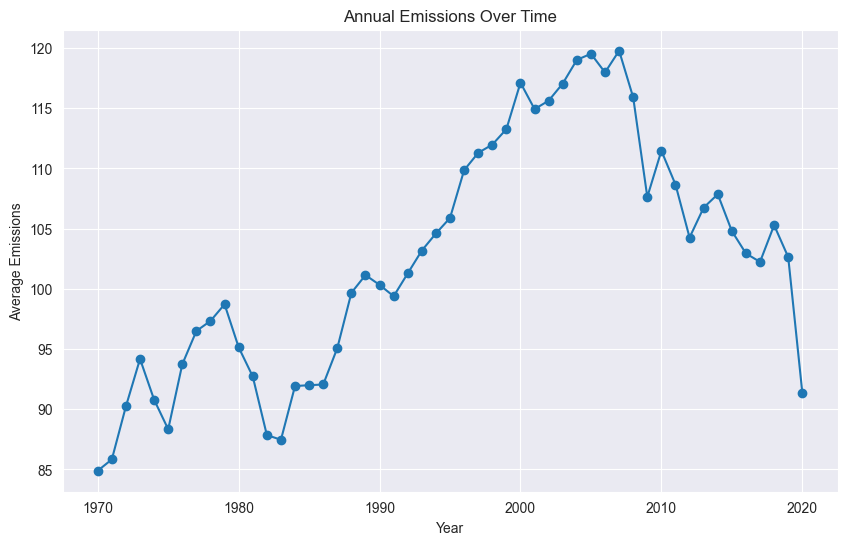

In [23]:
emissions_by_year = final_df_imputed_normalized.groupby('year')['emissions'].mean().reset_index()
print(emissions_by_year)
plt.figure(figsize=(10, 6))
plt.plot(emissions_by_year['year'], emissions_by_year['emissions'], marker='o')
plt.title('Annual Emissions Over Time')
plt.xlabel('Year')
plt.ylabel('Average Emissions')
plt.grid(True)
plt.show()

Average absolute change in national emissions year-over-year: 2.5879
Average total emissions per year: 102.5394
Change as percentage of average total emissions: 2.52%


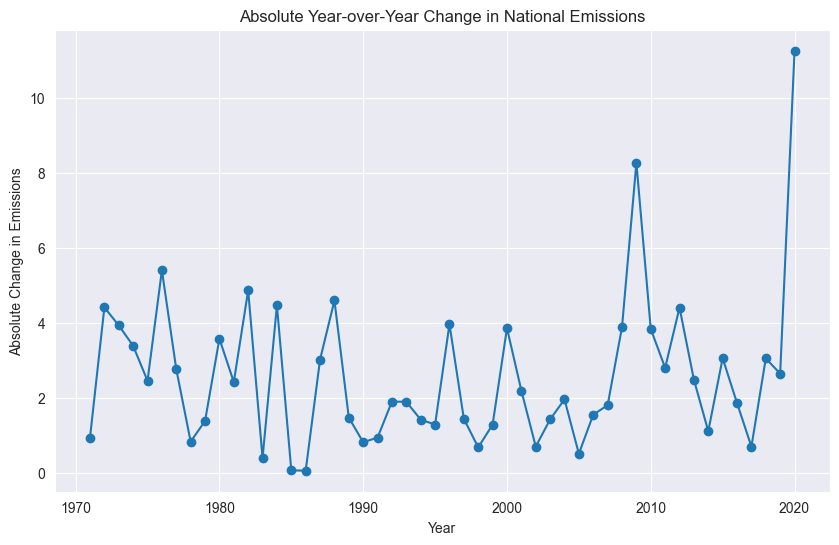

In [24]:
overall_yearly_mean = final_df_imputed_normalized.groupby('year')['emissions'].mean().rename('overall_mean')

overall_yearly_mean = overall_yearly_mean.sort_index()
yearly_changes = overall_yearly_mean.diff().dropna()
average_yearly_change = yearly_changes.abs().mean()
average_total_emissions = overall_yearly_mean.mean()
change_percentage = (average_yearly_change / average_total_emissions) * 100

print(f"Average absolute change in national emissions year-over-year: {average_yearly_change:.4f}")
print(f"Average total emissions per year: {average_total_emissions:.4f}")
print(f"Change as percentage of average total emissions: {change_percentage:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(yearly_changes.index, yearly_changes.abs(), marker='o')
plt.title('Absolute Year-over-Year Change in National Emissions')
plt.xlabel('Year')
plt.ylabel('Absolute Change in Emissions')
plt.grid(True)
plt.show()


#### Final Results

In [25]:
# Final dataframes are:
#   1. final_df_dropped_normalized
#   2. final_df_dropped
#   3. final_df_imputed_normalized
#   4. final_df_imputed

In [26]:
final_df = final_df_imputed.drop(columns=['Policy Scores'])
final_df_normalized = final_df_imputed_normalized.drop(columns=['Policy Scores'])

In [27]:
df_modified_normalized = final_df_normalized.copy()
df_modified_normalized['emissions_per_capita'] = df_modified_normalized['emissions'] / df_modified_normalized['population']
df_modified_normalized['population_density'] = df_modified_normalized['population'] / df_modified_normalized['size']
df_modified_normalized = df_modified_normalized.drop(columns=['population', 'size', 'emissions'])

df_modified = final_df.copy()
df_modified['emissions_per_capita'] = df_modified['emissions'] / df_modified['population']
df_modified['population_density'] = df_modified['population'] / df_modified['size']
df_modified = df_modified.drop(columns=['population', 'size', 'emissions'])

## Final Analysis

### Linear Models

#### Linear Regression

In [28]:
def train_linear_regression_forecasting(df, window_size=3, n_splits=5, use_ridge=False, ridge_alpha=1.0):
    try:
        df['year'] = pd.to_numeric(df['year'], errors='coerce')
        df = df.sort_values(['state', 'year'])

        if 'state' not in df.columns or 'emissions' not in df.columns:
            print("Required columns ('state', 'emissions') are missing.")
            return

        lagged_dfs = []
        for lag in range(1, window_size + 1):
            lagged = df[['state', 'year', 'emissions']].copy()
            lagged['year'] += lag
            lagged.rename(columns={'emissions': f'emissions_t_minus_{lag}'}, inplace=True)
            lagged_dfs.append(lagged)

        for lagged in lagged_dfs:
            df = df.merge(lagged, on=['state', 'year'], how='inner')

        df = df.dropna()
        if df.empty:
            print("No data after sliding window merge.")
            return

        print(f"Shape after sliding window processing: {df.shape}")

        features = [f'emissions_t_minus_{i}' for i in range(window_size, 0, -1)] + \
                   ['population', 'size', 'party_affiliation_score']
        X = df[features]
        y = df['emissions']
        states = df['state']

        tscv = TimeSeriesSplit(n_splits=n_splits)
        r2_scores, mse_scores, explained_scores = [], [], []
        coefs_all_folds = []
        top_feature_counts = []
        top_feature_fold_counts = []  # New: track top feature per fold
        all_r2_by_state = []

        plt.figure(figsize=(10, 6))

        for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            states_test = states.iloc[test_index]

            model = Ridge(alpha=ridge_alpha, normalize=True) if use_ridge else LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            explained_var = explained_variance_score(y_test, y_pred)

            print(f"Fold {fold} — R²: {r2:.4f}, MSE: {mse:.4f}, Explained Variance: {explained_var:.4f}")
            r2_scores.append(r2)
            mse_scores.append(mse)
            explained_scores.append(explained_var)
            coefs_all_folds.append(model.coef_)

            # New: track top feature for the fold
            top_feature_fold = pd.Series(model.coef_, index=features).abs().idxmax()
            top_feature_fold_counts.append(top_feature_fold)

            plt.scatter(y_test, y_pred, label=f'Fold {fold}', alpha=0.6)

            fold_df = df.iloc[test_index].copy()
            fold_df['predicted'] = y_pred
            fold_r2 = fold_df.groupby('state').apply(lambda g: r2_score(g['emissions'], g['predicted']))
            all_r2_by_state.append(fold_r2)

            for state, group in fold_df.groupby('state'):
                if len(group) < window_size + 3:
                    continue
                X_state = group[features]
                y_state = group['emissions']
                model_state = Ridge(alpha=ridge_alpha, normalize=True) if use_ridge else LinearRegression()
                model_state.fit(X_state, y_state)
                coefs = pd.Series(model_state.coef_, index=features).abs()
                top_feature = coefs.idxmax()
                top_feature_counts.append(top_feature)

        min_val, max_val = y.min(), y.max()
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')
        plt.xlabel('Actual Emissions')
        plt.ylabel('Predicted Emissions')
        plt.title('Ridge Regression' if use_ridge else 'Linear Regression')
        plt.legend(title='Fold')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"\nAverage R² Score: {np.mean(r2_scores):.4f}")
        print(f"Average Mean Squared Error: {np.mean(mse_scores):.4f}")
        print(f"Average Explained Variance Score: {np.mean(explained_scores):.4f}")

        coef_matrix = np.array(coefs_all_folds)
        mean_coefs = coef_matrix.mean(axis=0)
        std_coefs = coef_matrix.std(axis=0)
        coef_df = pd.DataFrame({
            'Feature': features,
            'Mean Coefficient': mean_coefs,
            'Std Deviation': std_coefs
        }).sort_values(by='Mean Coefficient', key=abs, ascending=False)

        print("\nAverage Feature Coefficients Across All Folds:")
        print(coef_df)

        r2_by_state_all_folds = pd.concat(all_r2_by_state, axis=1).mean(axis=1)
        stratified_r2 = r2_by_state_all_folds.mean()

        print(f"\nStratified R² (average across states): {stratified_r2:.4f}")
        print(f"Highest R² State: {r2_by_state_all_folds.idxmax()} ({r2_by_state_all_folds.max():.4f})")
        print(f"Lowest R² State: {r2_by_state_all_folds.idxmin()} ({r2_by_state_all_folds.min():.4f})")

        plt.figure(figsize=(12, 6))
        r2_by_state_all_folds.sort_values(ascending=False).plot(kind='bar')
        plt.axhline(0, color='red', linestyle='--')
        plt.title('R² by State (Averaged Across Folds)')
        plt.xlabel('State')
        plt.ylabel('R² Score')
        plt.tight_layout()
        plt.show()

        percent_party_top = (sum(f == 'party_affiliation_score' for f in top_feature_counts) / len(top_feature_counts)) * 100
        print(f"\nPercentage of state models (across all folds) where 'party_affiliation_score' was the top predictor: {percent_party_top:.2f}%")

        percent_party_top_fold = (sum(f == 'party_affiliation_score' for f in top_feature_fold_counts) / len(top_feature_fold_counts)) * 100
        print(f"Percentage of folds where 'party_affiliation_score' was the top predictor: {percent_party_top_fold:.2f}%")

        return (
            r2_scores,
            mse_scores,
            explained_scores,
            coef_df,
            stratified_r2,
            r2_by_state_all_folds.sort_values(ascending=False),
            percent_party_top,
            percent_party_top_fold
        )

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None


##### Normal

Shape after sliding window processing: (2050, 16)
Fold 1 — R²: 0.9931, MSE: 43.9691, Explained Variance: 0.9931
Fold 2 — R²: 0.9928, MSE: 23.2942, Explained Variance: 0.9928
Fold 3 — R²: 0.9936, MSE: 14.6526, Explained Variance: 0.9936
Fold 4 — R²: 0.9959, MSE: 35.1156, Explained Variance: 0.9959
Fold 5 — R²: 0.9982, MSE: 58.4965, Explained Variance: 0.9982


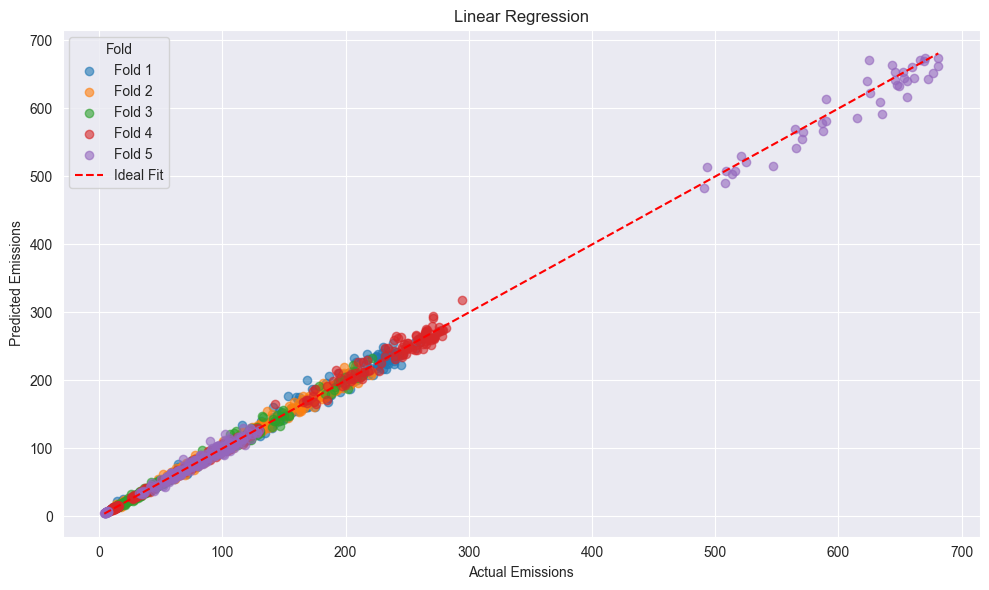


Average R² Score: 0.9947
Average Mean Squared Error: 35.1056
Average Explained Variance Score: 0.9947

Average Feature Coefficients Across All Folds:
                    Feature  Mean Coefficient  Std Deviation
12  party_affiliation_score          1.707612       0.921725
9       emissions_t_minus_1          1.063164       0.010568
1       emissions_t_minus_9         -0.256167       0.008352
2       emissions_t_minus_8          0.188869       0.009778
10               population          0.131111       0.109453
7       emissions_t_minus_3          0.114039       0.105950
8       emissions_t_minus_2         -0.104911       0.043051
0      emissions_t_minus_10          0.089641       0.009440
5       emissions_t_minus_5         -0.070343       0.020003
11                     size          0.055973       0.022439
6       emissions_t_minus_4         -0.054352       0.047130
3       emissions_t_minus_7          0.014584       0.028055
4       emissions_t_minus_6          0.007192       0.04

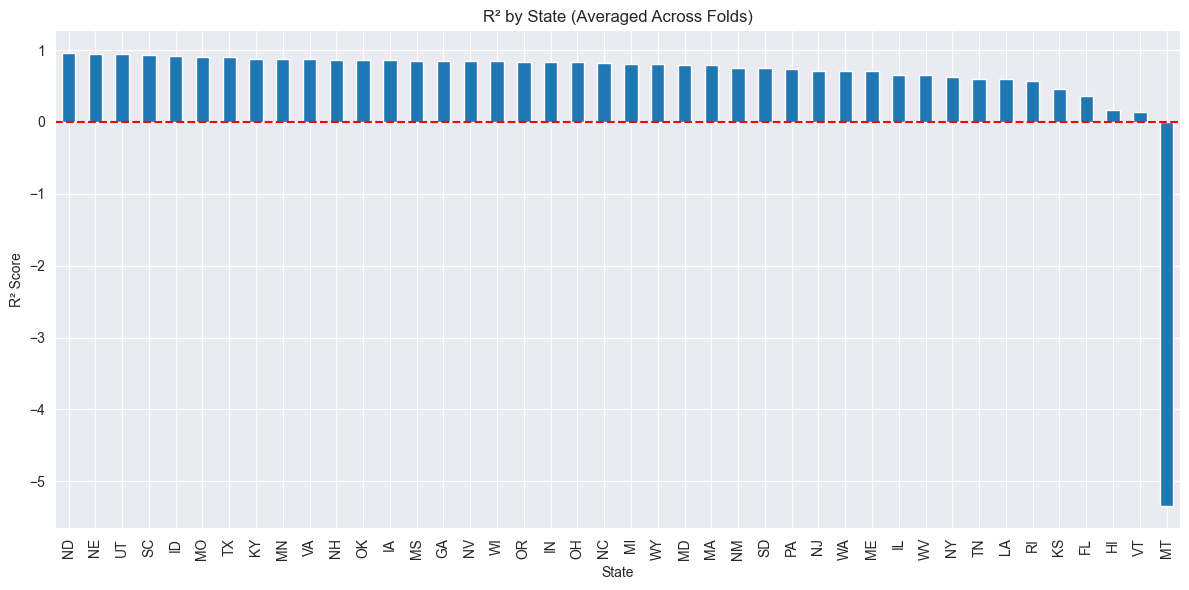


Percentage of state models (across all folds) where 'party_affiliation_score' was the top predictor: 6.82%
Percentage of folds where 'party_affiliation_score' was the top predictor: 60.00%


In [29]:
r2_scores, mse_scores, explained_scores, coef_df, stratified_r2, r2_by_state, percent_party_top, percent_party_top_fold = train_linear_regression_forecasting(final_df_normalized, window_size=10)

Shape after sliding window processing: (2300, 11)
Fold 1 — R²: 0.9936, MSE: 40.8220, Explained Variance: 0.9937
Fold 2 — R²: 0.9918, MSE: 26.7046, Explained Variance: 0.9919
Fold 3 — R²: 0.9930, MSE: 17.3458, Explained Variance: 0.9930
Fold 4 — R²: 0.9960, MSE: 36.8118, Explained Variance: 0.9960
Fold 5 — R²: 0.9979, MSE: 63.5495, Explained Variance: 0.9979


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


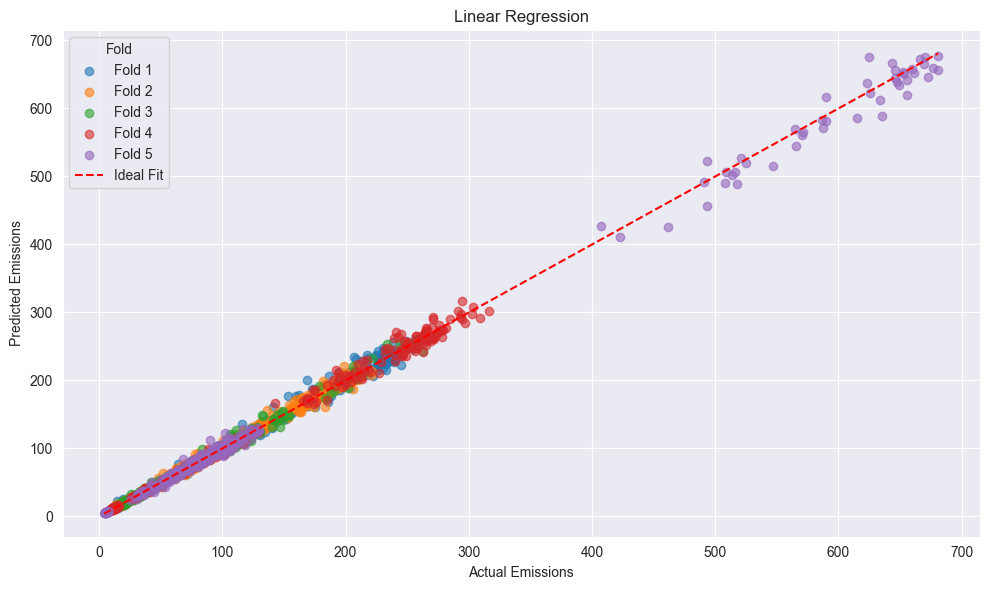


Average R² Score: 0.9945
Average Mean Squared Error: 37.0468
Average Explained Variance Score: 0.9945

Average Feature Coefficients Across All Folds:
                   Feature  Mean Coefficient  Std Deviation
7  party_affiliation_score          1.679056       1.386605
4      emissions_t_minus_1          1.055438       0.007714
0      emissions_t_minus_5         -0.102562       0.017725
3      emissions_t_minus_2         -0.091185       0.054083
2      emissions_t_minus_3          0.083490       0.120802
6                     size          0.075613       0.026921
1      emissions_t_minus_4          0.049715       0.064755
5               population          0.029609       0.132481

Stratified R² (average across states): 0.7902
Highest R² State: ND (0.9808)
Lowest R² State: HI (0.2516)


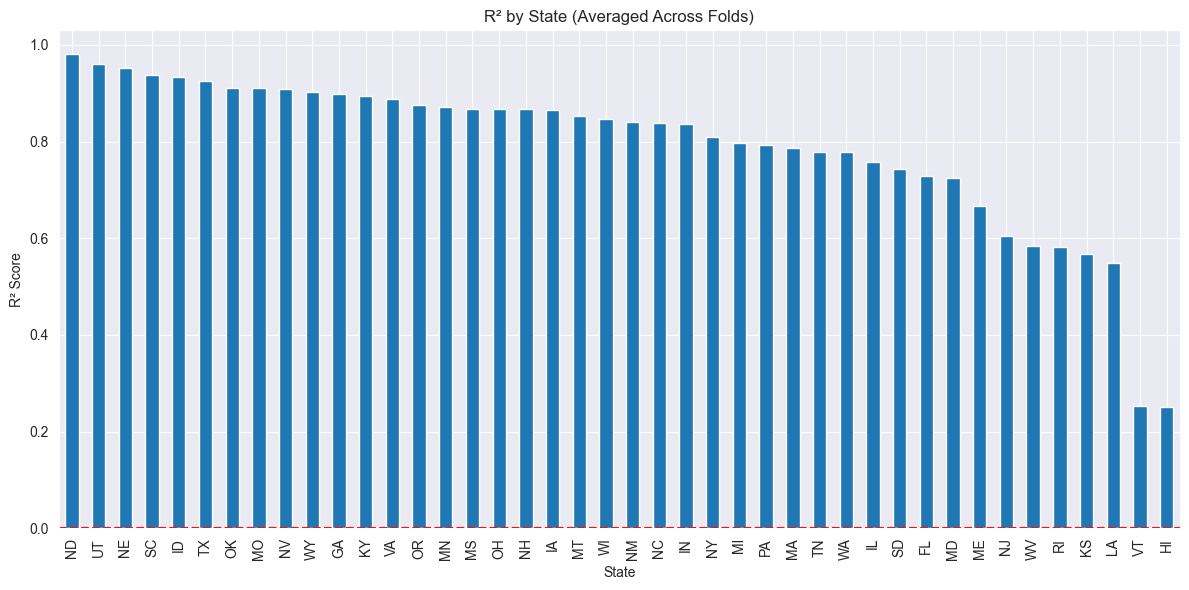


Percentage of state models (across all folds) where 'party_affiliation_score' was the top predictor: 17.78%
Percentage of folds where 'party_affiliation_score' was the top predictor: 60.00%


In [30]:
r2_scores, mse_scores, explained_scores, coef_df, stratified_r2, r2_by_state, percent_party_top, percent_party_top_fold = train_linear_regression_forecasting(final_df_normalized, window_size=5)

##### Ridge

Shape after sliding window processing: (2050, 16)
Fold 1 — R²: 0.9688, MSE: 198.7018, Explained Variance: 0.9692
Fold 2 — R²: 0.9660, MSE: 109.6931, Explained Variance: 0.9685
Fold 3 — R²: 0.9666, MSE: 76.1262, Explained Variance: 0.9710
Fold 4 — R²: 0.9858, MSE: 122.7037, Explained Variance: 0.9860
Fold 5 — R²: 0.9765, MSE: 743.7009, Explained Variance: 0.9783


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in 

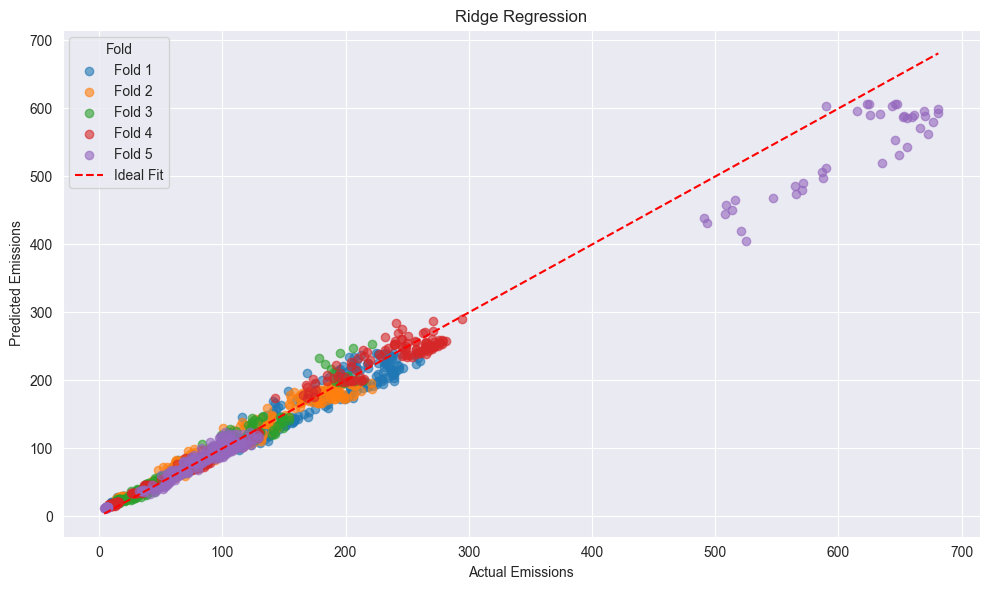


Average R² Score: 0.9727
Average Mean Squared Error: 250.1851
Average Explained Variance Score: 0.9746

Average Feature Coefficients Across All Folds:
                    Feature  Mean Coefficient  Std Deviation
10               population          4.319957       0.159854
12  party_affiliation_score          1.909575       0.695269
9       emissions_t_minus_1          0.112453       0.004612
8       emissions_t_minus_2          0.105009       0.003391
7       emissions_t_minus_3          0.099329       0.002764
6       emissions_t_minus_4          0.093095       0.001696
5       emissions_t_minus_5          0.087194       0.000794
4       emissions_t_minus_6          0.082825       0.000698
3       emissions_t_minus_7          0.080345       0.001259
2       emissions_t_minus_8          0.078267       0.001982
1       emissions_t_minus_9          0.074996       0.002888
0      emissions_t_minus_10          0.073681       0.003322
11                     size          0.073431       0.1

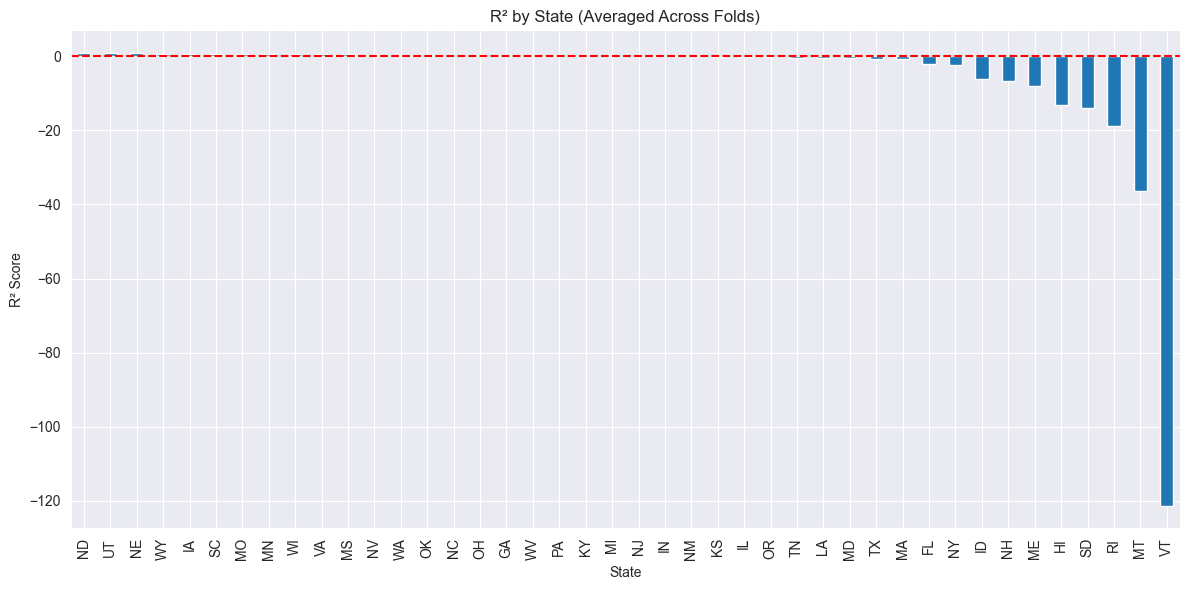


Percentage of state models (across all folds) where 'party_affiliation_score' was the top predictor: 18.18%
Percentage of folds where 'party_affiliation_score' was the top predictor: 0.00%


([0.9687748684375015,
  0.9660136956287757,
  0.9666232441691892,
  0.9857779370408885,
  0.9765276385575501],
 [198.70176904124452,
  109.6931134518442,
  76.12624808831677,
  122.70366463291863,
  743.700888861243],
 [0.9691919720697203,
  0.9684787599642148,
  0.9709867973236104,
  0.9859528941384511,
  0.9783357882708239],
                     Feature  Mean Coefficient  Std Deviation
 10               population          4.319957       0.159854
 12  party_affiliation_score          1.909575       0.695269
 9       emissions_t_minus_1          0.112453       0.004612
 8       emissions_t_minus_2          0.105009       0.003391
 7       emissions_t_minus_3          0.099329       0.002764
 6       emissions_t_minus_4          0.093095       0.001696
 5       emissions_t_minus_5          0.087194       0.000794
 4       emissions_t_minus_6          0.082825       0.000698
 3       emissions_t_minus_7          0.080345       0.001259
 2       emissions_t_minus_8          0.078267     

In [31]:
train_linear_regression_forecasting(final_df_normalized, window_size=10, n_splits=5, use_ridge=True, ridge_alpha=0.5)

Shape after sliding window processing: (2300, 11)
Fold 1 — R²: 0.9663, MSE: 215.9901, Explained Variance: 0.9692
Fold 2 — R²: 0.9587, MSE: 134.2263, Explained Variance: 0.9592
Fold 3 — R²: 0.9732, MSE: 66.7468, Explained Variance: 0.9826
Fold 4 — R²: 0.9822, MSE: 161.7210, Explained Variance: 0.9823
Fold 5 — R²: 0.9695, MSE: 921.8313, Explained Variance: 0.9718


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in 

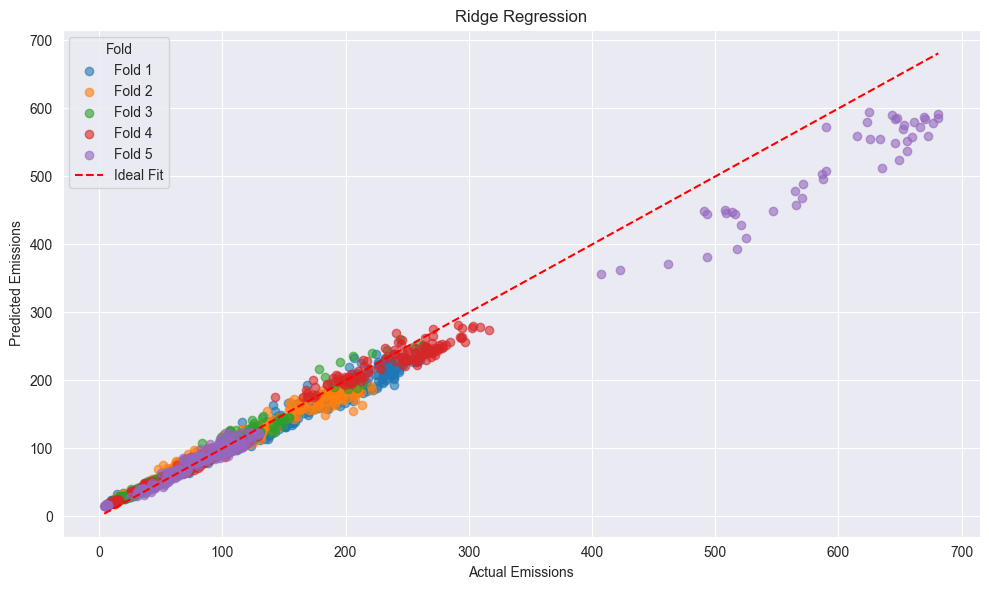


Average R² Score: 0.9700
Average Mean Squared Error: 300.1031
Average Explained Variance Score: 0.9730

Average Feature Coefficients Across All Folds:
                   Feature  Mean Coefficient  Std Deviation
5               population          7.588431       0.344472
7  party_affiliation_score          3.486554       0.723210
4      emissions_t_minus_1          0.173282       0.004054
3      emissions_t_minus_2          0.166675       0.003030
2      emissions_t_minus_3          0.162264       0.002768
1      emissions_t_minus_4          0.158373       0.002019
0      emissions_t_minus_5          0.155097       0.001448
6                     size         -0.093908       0.102653

Stratified R² (average across states): -9.3163
Highest R² State: WY (0.9220)
Lowest R² State: VT (-256.2162)


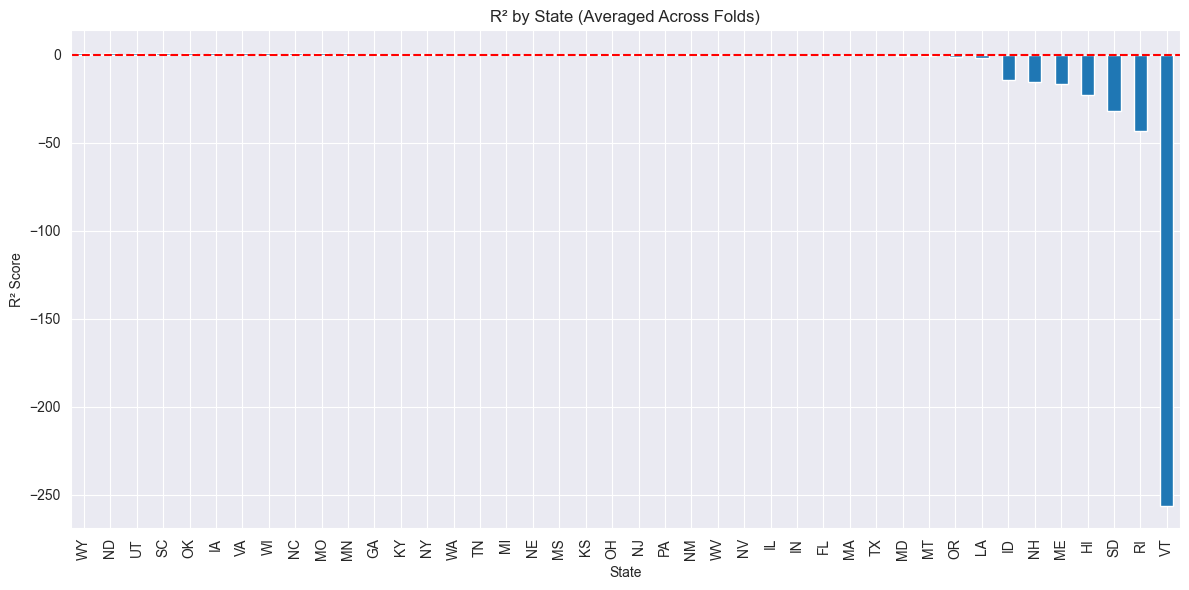


Percentage of state models (across all folds) where 'party_affiliation_score' was the top predictor: 22.22%
Percentage of folds where 'party_affiliation_score' was the top predictor: 0.00%


([0.9663073386823434,
  0.9587322684084625,
  0.9731918516428135,
  0.9822151995905635,
  0.9695363930519073],
 [215.99005478113895,
  134.22634419225702,
  66.74677888014895,
  161.7210342360001,
  921.8313450092534],
 [0.9691664502947247,
  0.9591899753360956,
  0.9826387430784973,
  0.9822514958210168,
  0.971754173155761],
                    Feature  Mean Coefficient  Std Deviation
 5               population          7.588431       0.344472
 7  party_affiliation_score          3.486554       0.723210
 4      emissions_t_minus_1          0.173282       0.004054
 3      emissions_t_minus_2          0.166675       0.003030
 2      emissions_t_minus_3          0.162264       0.002768
 1      emissions_t_minus_4          0.158373       0.002019
 0      emissions_t_minus_5          0.155097       0.001448
 6                     size         -0.093908       0.102653,
 -9.316300690954465,
 WY      0.922045
 ND      0.920340
 UT      0.880627
 SC      0.803952
 OK      0.774159
 IA      0

In [32]:
train_linear_regression_forecasting(final_df_normalized, window_size=5, n_splits=5, use_ridge=True, ridge_alpha=0.5)

#### Clustering

In [33]:
final_df_normalized_copy = final_df_normalized

final_df_normalized_copy['emissions_change'] = (
    final_df_normalized_copy
    .sort_values(['state', 'year'])
    .groupby('state')['emissions']
    .diff()
)

state_means = final_df_normalized_copy.drop(columns=['year']).groupby('state').mean().reset_index()
r2_df = r2_by_state.reset_index()
r2_df.columns = ['state', 'r2_score']
merged_df = state_means.merge(r2_df, on='state', how='inner')
merged_df

,state,emissions,population,size,party_affiliation_score,emissions_change,r2_score
0,FL,195.523049,1.535937,-0.105611,-0.017853,2.046430,0.728186
1,GA,137.023641,0.368107,-0.171341,0.012679,0.846152,0.898038
2,HI,18.523540,-0.705806,-0.674646,0.027945,0.016553,0.251643
3,IA,68.401153,-0.405067,-0.204055,-0.030112,0.200772,0.864426
4,ID,13.792672,-0.695642,0.079248,-0.055363,0.178019,0.933565
5,IL,222.334932,1.134144,-0.187023,-0.057187,-1.575821,0.757486
6,IN,199.225585,0.100483,-0.410108,-0.013301,-0.368278,0.835436
7,KS,67.384685,-0.462341,0.065848,-0.080044,0.125072,0.568283
8,KY,124.347145,-0.236814,-0.368717,0.021223,0.288879,0.895184
9,LA,191.777423,-0.167456,-0.244481,0.038683,0.755896,0.549003


In [34]:
def analyze_r2_clusters_from_merged(merged_df, max_k=10):
    try:
        clustering_features = ['r2_score', 'party_affiliation_score', 'emissions_change', 'population', 'size', 'emissions']

        for col in clustering_features:
            merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

        merged_df[clustering_features] = merged_df[clustering_features].fillna(
            merged_df[clustering_features].mean()
        )

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(merged_df[clustering_features])

        sse = []
        K_range = range(1, min(len(X_scaled), max_k) + 1)
        for k in K_range:
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            km.fit(X_scaled)
            sse.append(km.inertia_)

        kn = KneeLocator(K_range, sse, curve='convex', direction='decreasing')
        optimal_k = kn.elbow if kn.elbow is not None else 3  # fallback if not found

        plt.figure(figsize=(6, 4))
        plt.plot(K_range, sse, marker='o')
        if kn.elbow:
            plt.axvline(x=kn.elbow, color='red', linestyle='--', label=f'Elbow at k={kn.elbow}')
            plt.legend()
        plt.title('Elbow Method to Determine Optimal Clusters')
        plt.xlabel('Number of Clusters')
        plt.ylabel('SSE (Inertia)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"✅ Optimal number of clusters selected: {optimal_k}")

        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        merged_df['cluster'] = kmeans.fit_predict(X_scaled)

        cluster_summary = merged_df.groupby('cluster')[clustering_features].mean().round(3)
        feature_ranges = cluster_summary.max() - cluster_summary.min()
        top_discriminative_features = feature_ranges.sort_values(ascending=False)

        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=merged_df,
            x='party_affiliation_score',
            y='r2_score',
            hue='cluster',
            palette='viridis',
            s=100
        )
        plt.axhline(0, color='red', linestyle='--')
        plt.title('State R² vs. Party Affiliation Score (Clustered)')
        plt.xlabel('Party Affiliation Score')
        plt.ylabel('R² Score')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print("\nCluster Summary:")
        print(cluster_summary)

        print("\nTop Discriminative Features Across Clusters:")
        print(top_discriminative_features)

        return merged_df, cluster_summary, top_discriminative_features

    except Exception as e:
        print(f"\n❌ An error occurred in clustering: {e}")
        return None

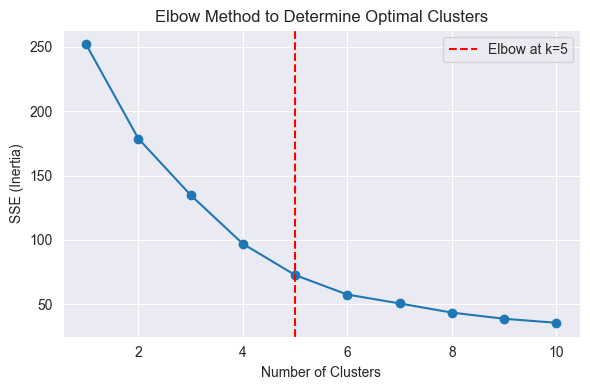

✅ Optimal number of clusters selected: 5


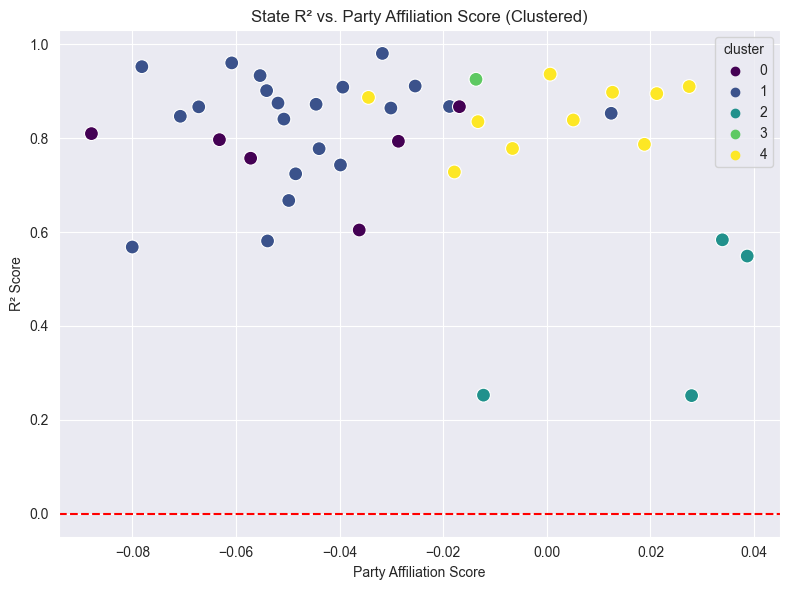


Cluster Summary:
         r2_score  party_affiliation_score  emissions_change  population  \
cluster                                                                    
0           0.772                   -0.048            -1.743       1.121   
1           0.833                   -0.047             0.254      -0.503   
2           0.409                    0.022             0.191      -0.567   
3           0.926                   -0.014             5.291       2.415   
4           0.850                    0.001             0.320       0.230   

          size  emissions  
cluster                    
0       -0.254    206.807  
1       -0.043     47.404  
2       -0.536     79.315  
3        2.000    572.447  
4       -0.318    124.875  

Top Discriminative Features Across Clusters:
emissions                  525.043
emissions_change             7.034
population                   2.982
size                         2.536
r2_score                     0.517
party_affiliation_score      0.0

In [35]:
clustered_df, summary_df, top_features = analyze_r2_clusters_from_merged(merged_df)

#### Logistic Regression

In [36]:
final_df_normalized_tmp = final_df_normalized_copy
final_df_normalized_tmp['political_party'] = final_df_normalized['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')
scaler = StandardScaler()
final_df_normalized_tmp['emissions'] = scaler.fit_transform(final_df_normalized_tmp[['emissions']])
final_df_normalized_tmp

,state,year,emissions,population,size,party_affiliation_score,emissions_change,political_party
0,AL,1970.0,0.001733,-0.317917,-0.244045,-0.030073,NaN,R
1,AL,1971.0,-0.039189,-0.308976,-0.244045,-0.030073,-4.200904,R
2,AL,1972.0,0.023821,-0.301798,-0.244045,-0.030073,6.468385,R
3,AL,1973.0,0.068955,-0.294949,-0.244045,-0.030073,4.633286,R
4,AL,1974.0,0.061298,-0.287026,-0.244045,-0.030073,-0.786126,R
...,...,...,...,...,...,...,...,...
2545,WY,2016.0,-0.404303,-0.802811,0.227085,-0.280461,-2.884226,R
2546,WY,2017.0,-0.389217,-0.803701,0.227085,-0.030073,1.548672,R
2547,WY,2018.0,-0.378935,-0.803861,0.227085,-0.030073,1.055560,R
2548,WY,2019.0,-0.425124,-0.803681,0.227085,-0.030073,-4.741650,R


In [37]:
def average_change_by_party(df, value_column='emissions', party_column='political_party'):
    df = df.sort_values(['state', 'year'])
    df['value_diff'] = df.groupby('state')[value_column].diff()
    state_avg_change = df.groupby('state')['value_diff'].mean().reset_index()
    party_map = df.drop_duplicates('state')[['state', party_column]]
    merged = state_avg_change.merge(party_map, on='state', how='left')
    result = merged.groupby(party_column)['value_diff'].mean().reset_index().rename(columns={'value_diff': 'avg_change'})
    return result

average_change_by_party(final_df_normalized_tmp)

,political_party,avg_change
0,R,0.001265


In [38]:
counts = final_df_normalized_tmp['political_party'].value_counts(normalize=True) * 100
print(counts)

R    89.647059
D    10.352941
Name: political_party, dtype: float64


In [39]:
def train_logistic_regression_forecasting(
    df,
    window_size=3,
    n_splits=5,
    penalty='l2',
    C=1.0,
    exclude_demo_features=False,
    shuffle_labels=True
):
    try:
        df['year'] = pd.to_numeric(df['year'], errors='coerce')
        df = df.sort_values(['state', 'year'])

        if 'state' not in df.columns or 'political_party' not in df.columns:
            print("Required columns ('state', 'political_party') are missing.")
            return

        lagged_dfs = []
        for lag in range(1, window_size + 1):
            lagged = df[['state', 'year', 'emissions']].copy()
            lagged['year'] += lag
            lagged.rename(columns={'emissions': f'emissions_t_minus_{lag}'}, inplace=True)
            lagged_dfs.append(lagged)

        for lagged in lagged_dfs:
            df = df.merge(lagged, on=['state', 'year'], how='inner')

        df = df.dropna()
        if df.empty:
            print("No data after sliding window merge.")
            return

        print(f"Shape after sliding window processing: {df.shape}")

        base_features = [f'emissions_t_minus_{i}' for i in range(window_size, 0, -1)]
        extra_features = ['population', 'size']
        features = base_features + ([] if exclude_demo_features else extra_features)

        X = df[features]
        y = df['political_party'].copy()
        states = df['state']

        if shuffle_labels:
            print("Shuffling political_party labels to test against random baseline...")
            y = y.sample(frac=1.0, random_state=42).reset_index(drop=True)

        tscv = TimeSeriesSplit(n_splits=n_splits)
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []
        coefs_all_folds = []
        top_feature_counts = []

        plt.figure(figsize=(10, 6))

        for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            states_test = states.iloc[test_index]

            if len(np.unique(y_train)) < 2:
                print(f"Fold {fold} skipped — only one class ({np.unique(y_train)[0]}) present in training data.")
                continue

            model = LogisticRegression(penalty=penalty, C=C, max_iter=1000)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, pos_label='R', zero_division=0)
            rec = recall_score(y_test, y_pred, pos_label='R', zero_division=0)
            f1 = f1_score(y_test, y_pred, pos_label='R', zero_division=0)

            accuracy_scores.append(acc)
            precision_scores.append(prec)
            recall_scores.append(rec)
            f1_scores.append(f1)
            coefs_all_folds.append(model.coef_[0])

            print(f"Fold {fold} — Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
            plt.scatter(range(len(y_test)), y_pred, alpha=0.6, label=f'Fold {fold}')

            fold_df = df.iloc[test_index].copy()
            for state, group in fold_df.groupby('state'):
                if len(group) < window_size + 3:
                    continue
                X_state = group[features]
                y_state = y.iloc[group.index]
                if len(np.unique(y_state)) < 2:
                    continue
                model_state = LogisticRegression(penalty=penalty, C=C, max_iter=1000)
                model_state.fit(X_state, y_state)
                coefs = pd.Series(model_state.coef_[0], index=features).abs()
                top_feature = coefs.idxmax()
                top_feature_counts.append(top_feature)

            if fold == n_splits:
                final_test_df = pd.DataFrame({
                    'state': states_test.values,
                    'actual': y_test.values,
                    'predicted': y_pred
                })

        plt.xlabel('Sample Index')
        plt.ylabel('Predicted Political Party')
        plt.title('Logistic Regression Predictions by Fold')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        if not accuracy_scores:
            print("\nNo valid folds with both classes. Cannot compute overall metrics.")
            return None

        print(f"\nAverage Accuracy Across Folds:  {np.mean(accuracy_scores):.4f}")
        print(f"Average Precision (R):          {np.mean(precision_scores):.4f}")
        print(f"Average Recall (R):             {np.mean(recall_scores):.4f}")
        print(f"Average F1 Score (R):           {np.mean(f1_scores):.4f}")

        coef_matrix = np.array(coefs_all_folds)
        mean_coefs = coef_matrix.mean(axis=0)
        std_coefs = coef_matrix.std(axis=0)

        coef_df = pd.DataFrame({
            'Feature': features,
            'Mean Coefficient': mean_coefs,
            'Std Deviation': std_coefs
        }).sort_values(by='Mean Coefficient', key=abs, ascending=False)

        print("\nAverage Feature Coefficients Across All Folds:")
        print(coef_df)

        non_lag_df = coef_df[~coef_df['Feature'].str.startswith('emissions_t_minus_')]
        print("\nNon-Lag Feature Coefficients (Excludes emissions_t_minus_X):")
        print(non_lag_df)

        accuracy_by_state = final_test_df.groupby('state').apply(lambda g: accuracy_score(g['actual'], g['predicted']))
        stratified_accuracy = accuracy_by_state.mean()

        print(f"\nStratified Accuracy (average across states): {stratified_accuracy:.4f}")
        print(f"Highest Accuracy State: {accuracy_by_state.idxmax()} ({accuracy_by_state.max():.4f})")
        print(f"Lowest Accuracy State: {accuracy_by_state.idxmin()} ({accuracy_by_state.min():.4f})")

        plt.figure(figsize=(12, 6))
        accuracy_by_state.sort_values(ascending=False).plot(kind='bar')
        plt.axhline(0.5, color='red', linestyle='--')
        plt.title('Accuracy by State (Last Fold)')
        plt.xlabel('State')
        plt.ylabel('Accuracy')
        plt.tight_layout()
        plt.show()

        total_state_models = len(top_feature_counts)
        top_feature_counts_series = pd.Series(top_feature_counts)
        top_feature_counts_percent = top_feature_counts_series.value_counts(normalize=True) * 100

        print("\nTop Feature Frequency (Percent of States Where Each Feature Was Most Predictive):")
        print(top_feature_counts_percent)

        return (
            accuracy_scores,
            coef_df,
            non_lag_df,
            stratified_accuracy,
            accuracy_by_state.sort_values(ascending=False),
            top_feature_counts_percent
        )

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

Shape after sliding window processing: (2050, 18)
Shuffling political_party labels to test against random baseline...
Fold 1 — Accuracy: 0.8680, Precision: 0.8680, Recall: 1.0000, F1: 0.9294
Fold 2 — Accuracy: 0.8974, Precision: 0.8974, Recall: 1.0000, F1: 0.9459
Fold 3 — Accuracy: 0.8358, Precision: 0.8358, Recall: 1.0000, F1: 0.9105
Fold 4 — Accuracy: 0.8739, Precision: 0.8739, Recall: 1.0000, F1: 0.9327
Fold 5 — Accuracy: 0.8944, Precision: 0.8944, Recall: 1.0000, F1: 0.9443


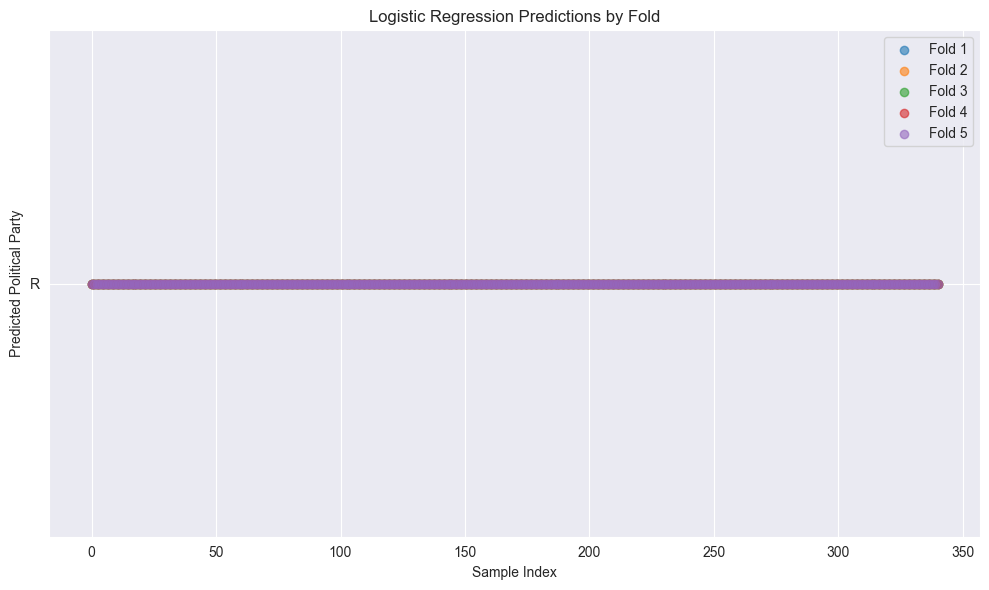


Average Accuracy Across Folds:  0.8739
Average Precision (R):          0.8739
Average Recall (R):             1.0000
Average F1 Score (R):           0.9326

Average Feature Coefficients Across All Folds:
                 Feature  Mean Coefficient  Std Deviation
9    emissions_t_minus_1         -0.602702       0.273914
7    emissions_t_minus_3          0.568435       0.097755
1    emissions_t_minus_9         -0.314457       0.063715
3    emissions_t_minus_7         -0.242105       0.223760
8    emissions_t_minus_2          0.223153       0.110985
11                  size          0.198720       0.047269
6    emissions_t_minus_4          0.198147       0.112219
5    emissions_t_minus_5          0.117385       0.212898
2    emissions_t_minus_8         -0.114238       0.179151
10            population          0.112932       0.184430
0   emissions_t_minus_10         -0.050795       0.091023
4    emissions_t_minus_6         -0.031071       0.122655

Non-Lag Feature Coefficients (Excludes e

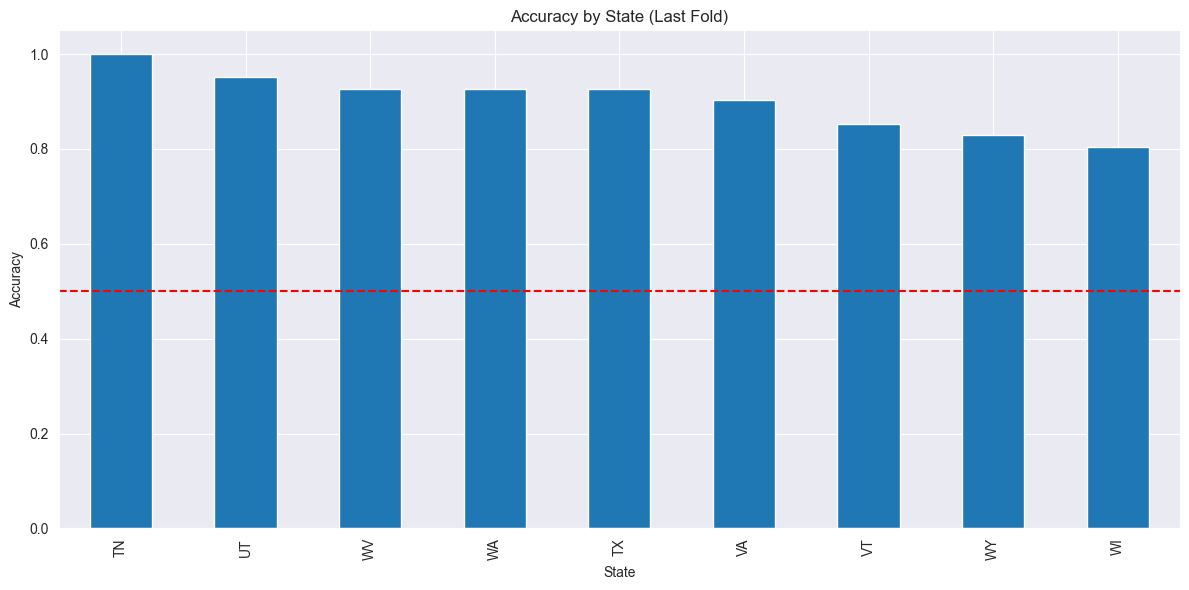


Top Feature Frequency (Percent of States Where Each Feature Was Most Predictive):
emissions_t_minus_10    23.255814
emissions_t_minus_6     13.953488
emissions_t_minus_9     11.627907
emissions_t_minus_5     11.627907
emissions_t_minus_1      9.302326
emissions_t_minus_7      6.976744
population               6.976744
emissions_t_minus_8      6.976744
emissions_t_minus_4      4.651163
emissions_t_minus_3      2.325581
emissions_t_minus_2      2.325581
dtype: float64


([0.8680351906158358,
  0.8973607038123167,
  0.8357771260997068,
  0.873900293255132,
  0.8944281524926686],
                  Feature  Mean Coefficient  Std Deviation
 9    emissions_t_minus_1         -0.602702       0.273914
 7    emissions_t_minus_3          0.568435       0.097755
 1    emissions_t_minus_9         -0.314457       0.063715
 3    emissions_t_minus_7         -0.242105       0.223760
 8    emissions_t_minus_2          0.223153       0.110985
 11                  size          0.198720       0.047269
 6    emissions_t_minus_4          0.198147       0.112219
 5    emissions_t_minus_5          0.117385       0.212898
 2    emissions_t_minus_8         -0.114238       0.179151
 10            population          0.112932       0.184430
 0   emissions_t_minus_10         -0.050795       0.091023
 4    emissions_t_minus_6         -0.031071       0.122655,
        Feature  Mean Coefficient  Std Deviation
 11        size          0.198720       0.047269
 10  population         

In [40]:
train_logistic_regression_forecasting(final_df_normalized_tmp, window_size=10)

Shape after sliding window processing: (2300, 13)
Shuffling political_party labels to test against random baseline...
Fold 1 — Accuracy: 0.8773, Precision: 0.8773, Recall: 1.0000, F1: 0.9346
Fold 2 — Accuracy: 0.8930, Precision: 0.8930, Recall: 1.0000, F1: 0.9434
Fold 3 — Accuracy: 0.8851, Precision: 0.8851, Recall: 1.0000, F1: 0.9391
Fold 4 — Accuracy: 0.8982, Precision: 0.8982, Recall: 1.0000, F1: 0.9464
Fold 5 — Accuracy: 0.8616, Precision: 0.8616, Recall: 1.0000, F1: 0.9257


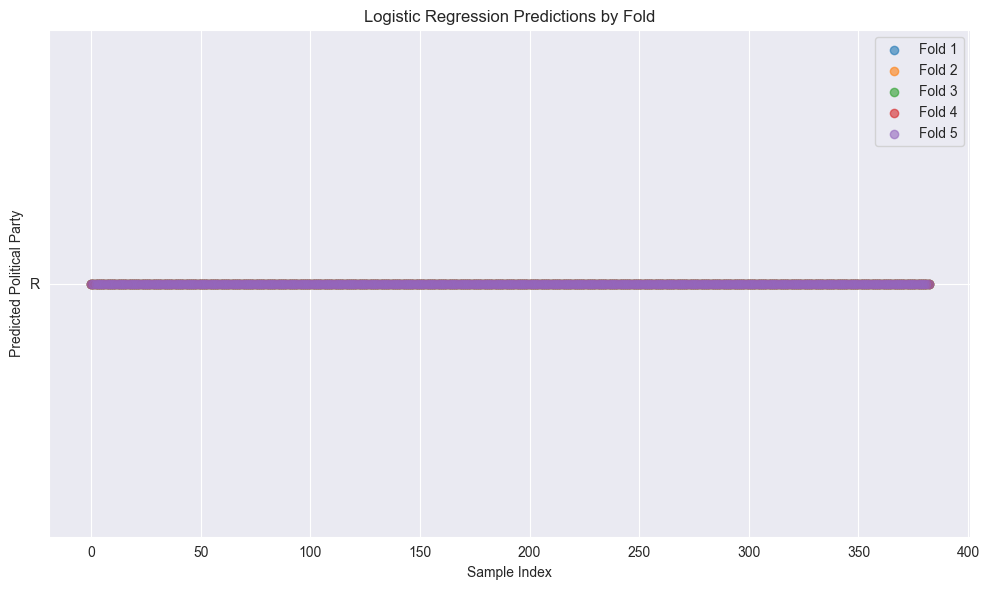


Average Accuracy Across Folds:  0.8830
Average Precision (R):          0.8830
Average Recall (R):             1.0000
Average F1 Score (R):           0.9378

Average Feature Coefficients Across All Folds:
               Feature  Mean Coefficient  Std Deviation
3  emissions_t_minus_2         -0.272484       0.141437
4  emissions_t_minus_1          0.260912       0.072479
1  emissions_t_minus_4         -0.181514       0.137566
5           population          0.129697       0.191231
2  emissions_t_minus_3         -0.111367       0.082495
0  emissions_t_minus_5          0.073654       0.261229
6                 size         -0.047826       0.013412

Non-Lag Feature Coefficients (Excludes emissions_t_minus_X):
      Feature  Mean Coefficient  Std Deviation
5  population          0.129697       0.191231
6        size         -0.047826       0.013412

Stratified Accuracy (average across states): 0.8570
Highest Accuracy State: WY (0.9348)
Lowest Accuracy State: TN (0.8000)


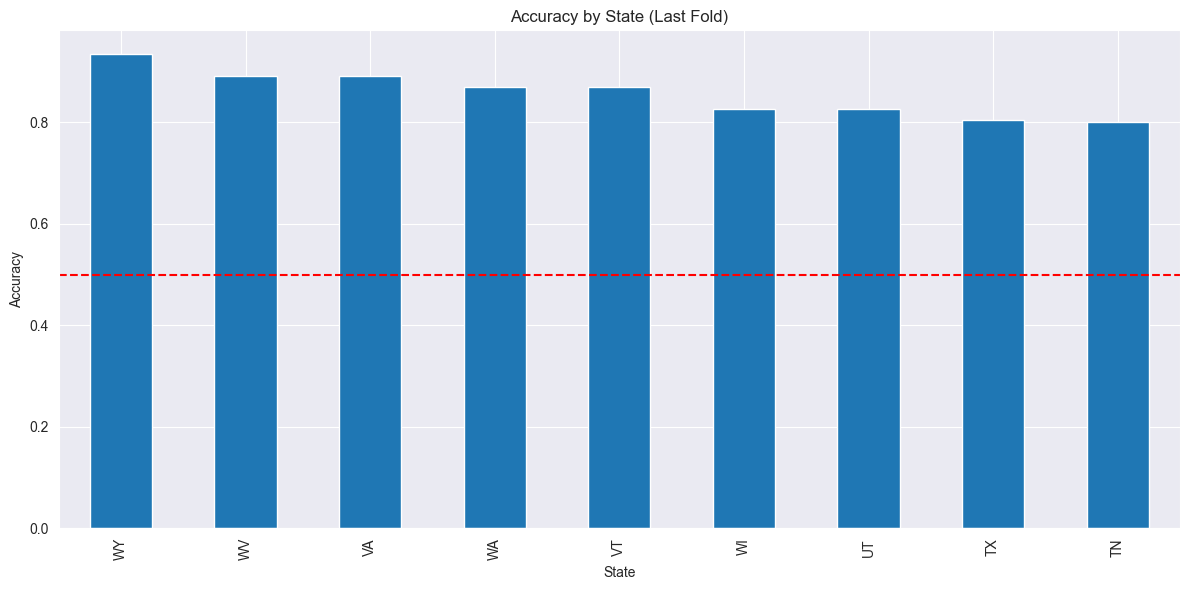


Top Feature Frequency (Percent of States Where Each Feature Was Most Predictive):
emissions_t_minus_5    22.727273
emissions_t_minus_2    22.727273
population             20.454545
emissions_t_minus_1    18.181818
emissions_t_minus_4     9.090909
emissions_t_minus_3     6.818182
dtype: float64


([0.8772845953002611,
  0.8929503916449086,
  0.8851174934725848,
  0.8981723237597912,
  0.8616187989556136],
                Feature  Mean Coefficient  Std Deviation
 3  emissions_t_minus_2         -0.272484       0.141437
 4  emissions_t_minus_1          0.260912       0.072479
 1  emissions_t_minus_4         -0.181514       0.137566
 5           population          0.129697       0.191231
 2  emissions_t_minus_3         -0.111367       0.082495
 0  emissions_t_minus_5          0.073654       0.261229
 6                 size         -0.047826       0.013412,
       Feature  Mean Coefficient  Std Deviation
 5  population          0.129697       0.191231
 6        size         -0.047826       0.013412,
 0.8570048309178744,
 state
 WY    0.934783
 WV    0.891304
 VA    0.891304
 WA    0.869565
 VT    0.869565
 WI    0.826087
 UT    0.826087
 TX    0.804348
 TN    0.800000
 dtype: float64,
 emissions_t_minus_5    22.727273
 emissions_t_minus_2    22.727273
 population             20.454

In [41]:
train_logistic_regression_forecasting(final_df_normalized_tmp, window_size=5)

#### Engineered Linear Regression

In [42]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def train_feature_engineered_lr(df, window_size=3, n_splits=5, use_ridge=False, ridge_alpha=1.0):
    try:
        df['year'] = pd.to_numeric(df['year'], errors='coerce')
        df = df.sort_values(['state', 'year'])

        if 'state' not in df.columns or 'emissions_per_capita' not in df.columns:
            print("Required columns ('state', 'emissions_per_capita') are missing.")
            return

        # Create lagged emissions_per_capita features
        lagged_dfs = []
        for lag in range(1, window_size + 1):
            lagged = df[['state', 'year', 'emissions_per_capita']].copy()
            lagged['year'] += lag
            lagged.rename(columns={'emissions_per_capita': f'emissions_t_minus_{lag}'}, inplace=True)
            lagged_dfs.append(lagged)

        for lagged in lagged_dfs:
            df = df.merge(lagged, on=['state', 'year'], how='inner')

        df = df.dropna()
        if df.empty:
            print("No data after sliding window merge.")
            return

        print(f"Shape after sliding window processing: {df.shape}")

        features = [f'emissions_t_minus_{i}' for i in range(window_size, 0, -1)] + ['population_density']
        X = df[features]
        y = df['party_affiliation_score']
        states = df['state']

        tscv = TimeSeriesSplit(n_splits=n_splits)
        r2_scores, mse_scores, explained_scores = [], [], []
        coefs_all_folds, top_feature_counts = [], []

        plt.figure(figsize=(10, 6))

        for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            states_test = states.iloc[test_idx]

            model = Ridge(alpha=ridge_alpha) if use_ridge else LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            explained_var = explained_variance_score(y_test, y_pred)

            print(f"Fold {fold} — R²: {r2:.4f}, MSE: {mse:.4f}, Explained Variance: {explained_var:.4f}")
            r2_scores.append(r2)
            mse_scores.append(mse)
            explained_scores.append(explained_var)
            coefs_all_folds.append(model.coef_)

            plt.scatter(y_test, y_pred, label=f'Fold {fold}', alpha=0.6)

            # Feature importance tracking per state
            fold_df = df.iloc[test_idx].copy()
            for state, group in fold_df.groupby('state'):
                if len(group) < window_size + 3:
                    continue
                X_state = group[features]
                y_state = group['party_affiliation_score']
                model_state = Ridge(alpha=ridge_alpha) if use_ridge else LinearRegression()
                model_state.fit(X_state, y_state)
                coefs = pd.Series(model_state.coef_, index=features).abs()
                top_feature = coefs.idxmax()
                top_feature_counts.append(top_feature)

            if fold == n_splits:
                final_test_df = pd.DataFrame({
                    'state': states_test.values,
                    'actual': y_test.values,
                    'predicted': y_pred
                })

        min_val, max_val = min(y.min(), y.max()), max(y.min(), y.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')
        plt.xlabel('Actual Party Affiliation Score')
        plt.ylabel('Predicted Score')
        plt.title('Feature Engineered Linear Regression' + (' (Ridge)' if use_ridge else ''))
        plt.legend(title='Fold')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"\nAverage R² Score: {np.mean(r2_scores):.4f}")
        print(f"Average Mean Squared Error: {np.mean(mse_scores):.4f}")
        print(f"Average Explained Variance Score: {np.mean(explained_scores):.4f}")

        coef_matrix = np.array(coefs_all_folds)
        mean_coefs = coef_matrix.mean(axis=0)
        std_coefs = coef_matrix.std(axis=0)

        coef_df = pd.DataFrame({
            'Feature': features,
            'Mean Coefficient': mean_coefs,
            'Std Deviation': std_coefs
        }).sort_values(by='Mean Coefficient', key=abs, ascending=False)

        print("\nAverage Feature Coefficients Across All Folds:")
        print(coef_df)

        r2_by_state = final_test_df.groupby('state').apply(lambda g: r2_score(g['actual'], g['predicted']))
        stratified_r2 = r2_by_state.mean()

        print(f"\nStratified R² (average across states): {stratified_r2:.4f}")
        print(f"Highest R² State: {r2_by_state.idxmax()} ({r2_by_state.max():.4f})")
        print(f"Lowest R² State: {r2_by_state.idxmin()} ({r2_by_state.min():.4f})")

        plt.figure(figsize=(12, 6))
        r2_by_state.sort_values(ascending=False).plot(kind='bar')
        plt.axhline(0, color='red', linestyle='--')
        plt.title('R² by State (Last Fold)')
        plt.xlabel('State')
        plt.ylabel('R² Score')
        plt.tight_layout()
        plt.show()

        total_state_models = len(top_feature_counts)
        top_emissions_pct = (sum(f.startswith('emissions') for f in top_feature_counts) / total_state_models) * 100

        print(f"\nPercentage of state models where an 'emissions_t_minus_X' feature was most predictive: {top_emissions_pct:.2f}%")

        return r2_scores, mse_scores, explained_scores, coef_df, stratified_r2, r2_by_state.sort_values(ascending=False), top_emissions_pct

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None


Shape after sliding window processing: (2400, 8)
Fold 1 — R²: -0.1639, MSE: 0.0229, Explained Variance: -0.1533
Fold 2 — R²: -0.0666, MSE: 0.0190, Explained Variance: -0.0524
Fold 3 — R²: 0.0048, MSE: 0.0190, Explained Variance: 0.0091
Fold 4 — R²: -0.0158, MSE: 0.0161, Explained Variance: -0.0158
Fold 5 — R²: 0.0028, MSE: 0.0184, Explained Variance: 0.0030


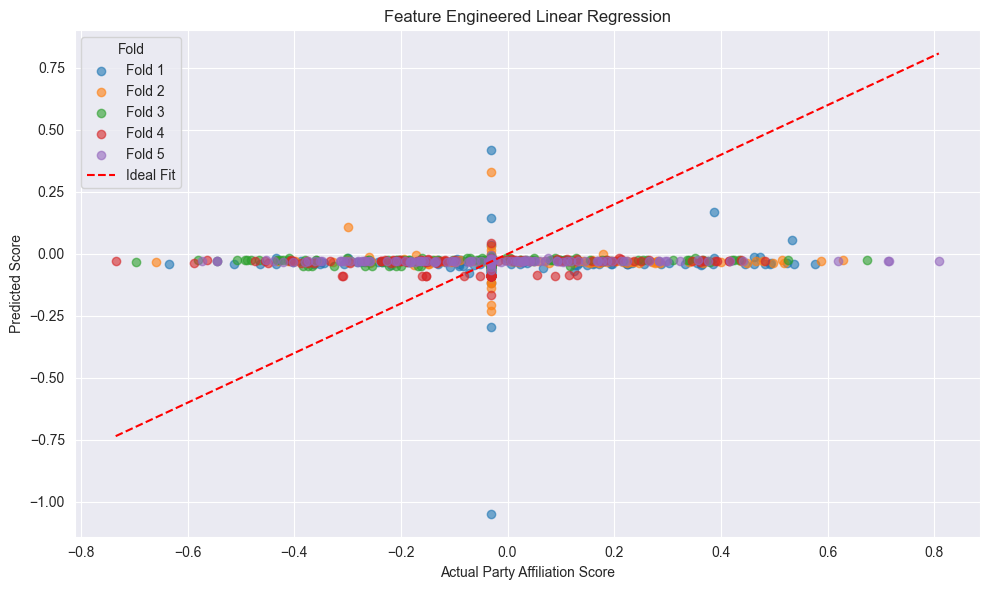


Average R² Score: -0.0478
Average Mean Squared Error: 0.0191
Average Explained Variance Score: -0.0419

Average Feature Coefficients Across All Folds:
               Feature  Mean Coefficient  Std Deviation
3   population_density      3.136796e-04   7.412379e-04
0  emissions_t_minus_3      2.447682e-06   2.136973e-06
1  emissions_t_minus_2     -1.840750e-06   3.897738e-06
2  emissions_t_minus_1     -3.304822e-07   8.693117e-07

Stratified R² (average across states): -0.0742
Highest R² State: VT (-0.0110)
Lowest R² State: TN (-0.2337)


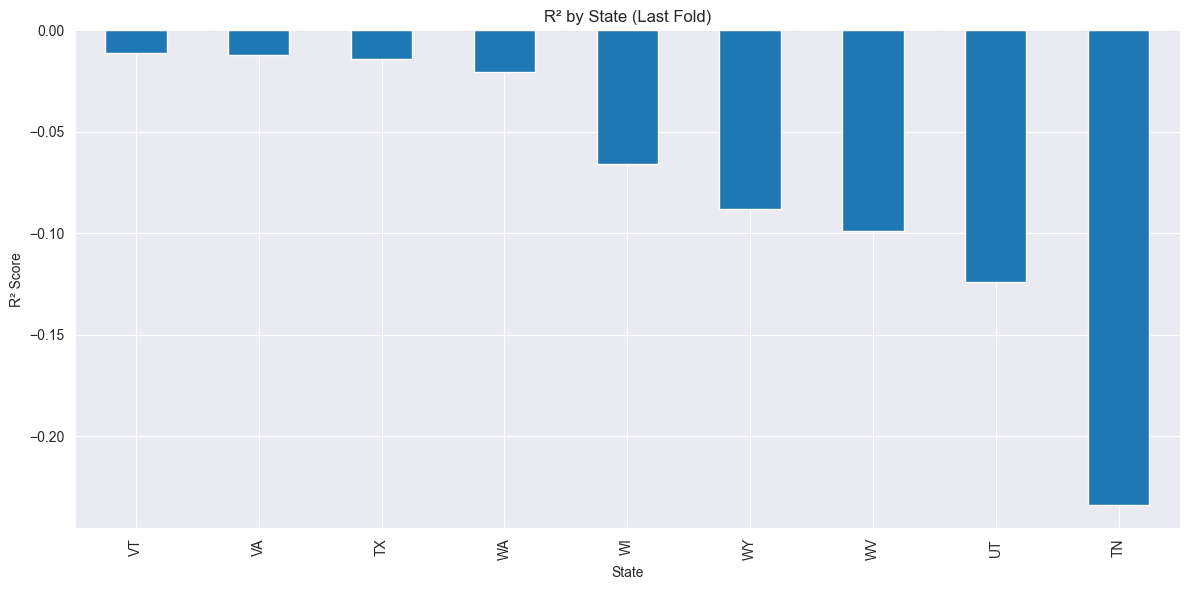


Percentage of state models where an 'emissions_t_minus_X' feature was most predictive: 2.22%


In [43]:
results = train_feature_engineered_lr(df_modified_normalized)

### Random Forest

In [44]:
final_df_tmp = final_df
final_df_tmp['political_party'] = final_df['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')
final_df_tmp

,state,year,emissions,population,size,party_affiliation_score,political_party
0,AL,1970.0,102.717308,-0.317917,-0.244045,-0.030073,R
1,AL,1971.0,98.516403,-0.308976,-0.244045,-0.030073,R
2,AL,1972.0,104.984789,-0.301798,-0.244045,-0.030073,R
3,AL,1973.0,109.618074,-0.294949,-0.244045,-0.030073,R
4,AL,1974.0,108.831948,-0.287026,-0.244045,-0.030073,R
...,...,...,...,...,...,...,...
2545,WY,2016.0,61.035090,-0.802811,0.227085,-0.280461,R
2546,WY,2017.0,62.583762,-0.803701,0.227085,-0.030073,R
2547,WY,2018.0,63.639323,-0.803861,0.227085,-0.030073,R
2548,WY,2019.0,58.897673,-0.803681,0.227085,-0.030073,R


In [48]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest_forecasting(df, window_size=5, n_splits=5, n_estimators=100, random_state=42):
    try:
        df['year'] = pd.to_numeric(df['year'], errors='coerce')
        df = df.sort_values(['state', 'year'])

        if 'state' not in df.columns or 'emissions' not in df.columns:
            print("Required columns ('state', 'emissions') are missing.")
            return

        lagged_dfs = []
        for lag in range(1, window_size + 1):
            lagged = df[['state', 'year', 'emissions']].copy()
            lagged['year'] += lag
            lagged.rename(columns={'emissions': f'emissions_t_minus_{lag}'}, inplace=True)
            lagged_dfs.append(lagged)

        for lagged in lagged_dfs:
            df = df.merge(lagged, on=['state', 'year'], how='inner')

        df = df.dropna()
        if df.empty:
            print("No data after sliding window merge.")
            return

        print(f"Shape after sliding window processing: {df.shape}")

        features = [f'emissions_t_minus_{i}' for i in range(window_size, 0, -1)] + \
                   ['population', 'size', 'party_affiliation_score']
        X = df[features]
        y = df['emissions']
        states = df['state']

        tscv = TimeSeriesSplit(n_splits=n_splits)
        r2_scores, mse_scores, explained_scores = [], [], []
        feature_importance_all_folds = []
        top_feature_counts = []
        all_r2_by_state = []

        plt.figure(figsize=(10, 6))

        for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            states_test = states.iloc[test_index]

            model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            explained_var = explained_variance_score(y_test, y_pred)

            print(f"Fold {fold} — R²: {r2:.4f}, MSE: {mse:.4f}, Explained Variance: {explained_var:.4f}")
            r2_scores.append(r2)
            mse_scores.append(mse)
            explained_scores.append(explained_var)
            feature_importance_all_folds.append(model.feature_importances_)

            top_feature_fold = pd.Series(model.feature_importances_, index=features).idxmax()
            top_feature_counts.append(top_feature_fold)

            plt.scatter(y_test, y_pred, label=f'Fold {fold}', alpha=0.6)

            fold_df = df.iloc[test_index].copy()
            fold_df['predicted'] = y_pred
            fold_r2 = fold_df.groupby('state').apply(lambda g: r2_score(g['emissions'], g['predicted']))
            all_r2_by_state.append(fold_r2)

        min_val, max_val = y.min(), y.max()
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')
        plt.xlabel('Actual Emissions')
        plt.ylabel('Predicted Emissions')
        plt.title('Random Forest Regression')
        plt.legend(title='Fold')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"\nAverage R² Score: {np.mean(r2_scores):.4f}")
        print(f"Average Mean Squared Error: {np.mean(mse_scores):.4f}")
        print(f"Average Explained Variance Score: {np.mean(explained_scores):.4f}")

        # Feature importances
        importances_matrix = np.array(feature_importance_all_folds)
        mean_importances = importances_matrix.mean(axis=0)
        std_importances = importances_matrix.std(axis=0)
        importance_df = pd.DataFrame({
            'Feature': features,
            'Mean Importance': mean_importances,
            'Std Deviation': std_importances
        }).sort_values(by='Mean Importance', ascending=False)

        print("\nAverage Feature Importances Across All Folds:")
        print(importance_df)

        # Stratified R² by state
        r2_by_state_all_folds = pd.concat(all_r2_by_state, axis=1).mean(axis=1)
        stratified_r2 = r2_by_state_all_folds.mean()

        print(f"\nStratified R² (average across states): {stratified_r2:.4f}")
        print(f"Highest R² State: {r2_by_state_all_folds.idxmax()} ({r2_by_state_all_folds.max():.4f})")
        print(f"Lowest R² State: {r2_by_state_all_folds.idxmin()} ({r2_by_state_all_folds.min():.4f})")

        plt.figure(figsize=(12, 6))
        r2_by_state_all_folds.sort_values(ascending=False).plot(kind='bar')
        plt.axhline(0, color='red', linestyle='--')
        plt.title('R² by State (Averaged Across Folds)')
        plt.xlabel('State')
        plt.ylabel('R² Score')
        plt.tight_layout()
        plt.show()

        percent_party_top = (sum(f == 'party_affiliation_score' for f in top_feature_counts) / len(top_feature_counts)) * 100
        print(f"\nPercentage of folds where 'party_affiliation_score' was the most important feature: {percent_party_top:.2f}%")

        return (
            r2_scores,
            mse_scores,
            explained_scores,
            importance_df,
            stratified_r2,
            r2_by_state_all_folds.sort_values(ascending=False),
            percent_party_top
        )

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None


Shape after sliding window processing: (2050, 17)
Fold 1 — R²: 0.9606, MSE: 250.6235, Explained Variance: 0.9606
Fold 2 — R²: 0.9891, MSE: 35.0481, Explained Variance: 0.9895
Fold 3 — R²: 0.9846, MSE: 35.0602, Explained Variance: 0.9851
Fold 4 — R²: 0.9896, MSE: 90.0715, Explained Variance: 0.9896
Fold 5 — R²: 0.7457, MSE: 8057.7167, Explained Variance: 0.7739


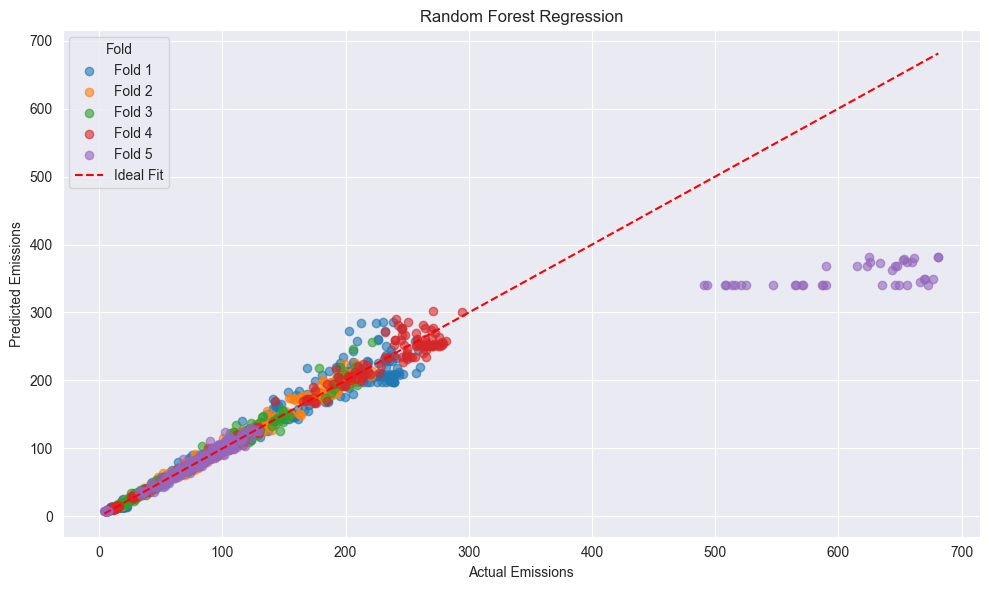


Average R² Score: 0.9339
Average Mean Squared Error: 1693.7040
Average Explained Variance Score: 0.9397

Average Feature Importances Across All Folds:
                    Feature  Mean Importance  Std Deviation
9       emissions_t_minus_1         0.732920       0.289371
8       emissions_t_minus_2         0.038791       0.033649
7       emissions_t_minus_3         0.037684       0.061616
2       emissions_t_minus_8         0.033228       0.039789
6       emissions_t_minus_4         0.026269       0.035564
4       emissions_t_minus_6         0.025397       0.037191
10               population         0.021424       0.022072
0      emissions_t_minus_10         0.018790       0.010614
3       emissions_t_minus_7         0.017946       0.025271
1       emissions_t_minus_9         0.017423       0.014771
5       emissions_t_minus_5         0.017066       0.022343
11                     size         0.012778       0.008256
12  party_affiliation_score         0.000284       0.000095

Stratif

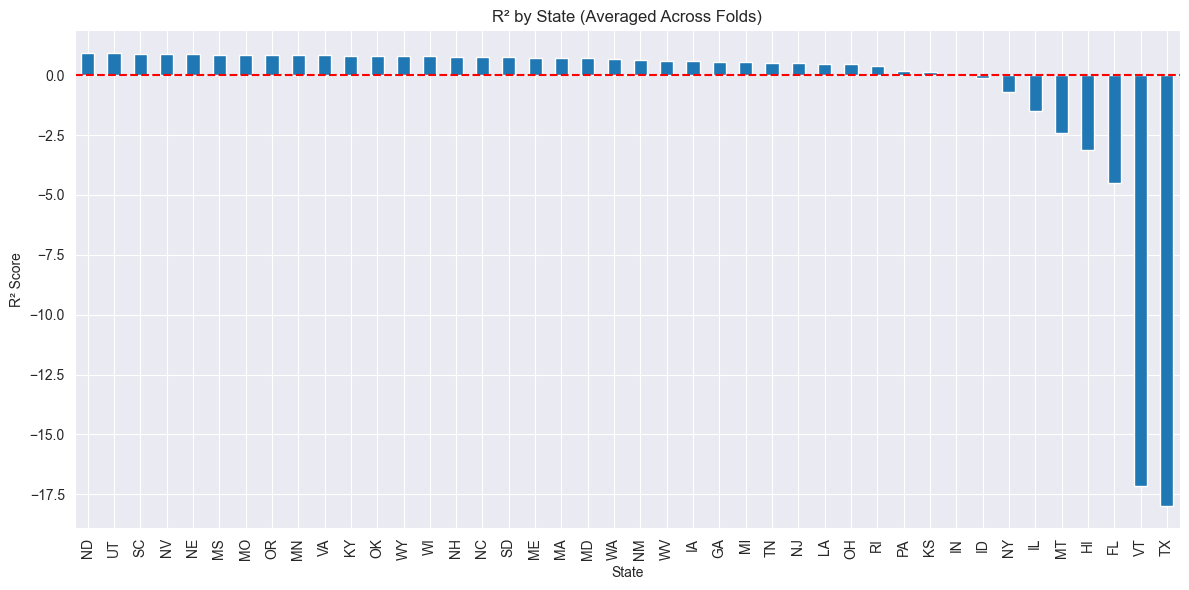


Percentage of folds where 'party_affiliation_score' was the most important feature: 0.00%


([0.9606155869375382,
  0.989141011928566,
  0.9846282406598187,
  0.9895601884483671,
  0.745685877316387],
 [250.6235252363516,
  35.04812401729024,
  35.06015896261291,
  90.07154160021105,
  8057.716713058157],
 [0.9606347347102668,
  0.9894615210325823,
  0.9851029926622906,
  0.9895844338000747,
  0.773899717284649],
                     Feature  Mean Importance  Std Deviation
 9       emissions_t_minus_1         0.732920       0.289371
 8       emissions_t_minus_2         0.038791       0.033649
 7       emissions_t_minus_3         0.037684       0.061616
 2       emissions_t_minus_8         0.033228       0.039789
 6       emissions_t_minus_4         0.026269       0.035564
 4       emissions_t_minus_6         0.025397       0.037191
 10               population         0.021424       0.022072
 0      emissions_t_minus_10         0.018790       0.010614
 3       emissions_t_minus_7         0.017946       0.025271
 1       emissions_t_minus_9         0.017423       0.014771
 5  

In [49]:
train_random_forest_forecasting(final_df_tmp, window_size=10)

Shape after sliding window processing: (2300, 12)
Fold 1 — R²: 0.9242, MSE: 485.9215, Explained Variance: 0.9276
Fold 2 — R²: 0.9889, MSE: 36.1829, Explained Variance: 0.9893


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Fold 3 — R²: 0.9903, MSE: 24.2416, Explained Variance: 0.9905
Fold 4 — R²: 0.9912, MSE: 80.1168, Explained Variance: 0.9913
Fold 5 — R²: 0.7971, MSE: 6141.2171, Explained Variance: 0.8181


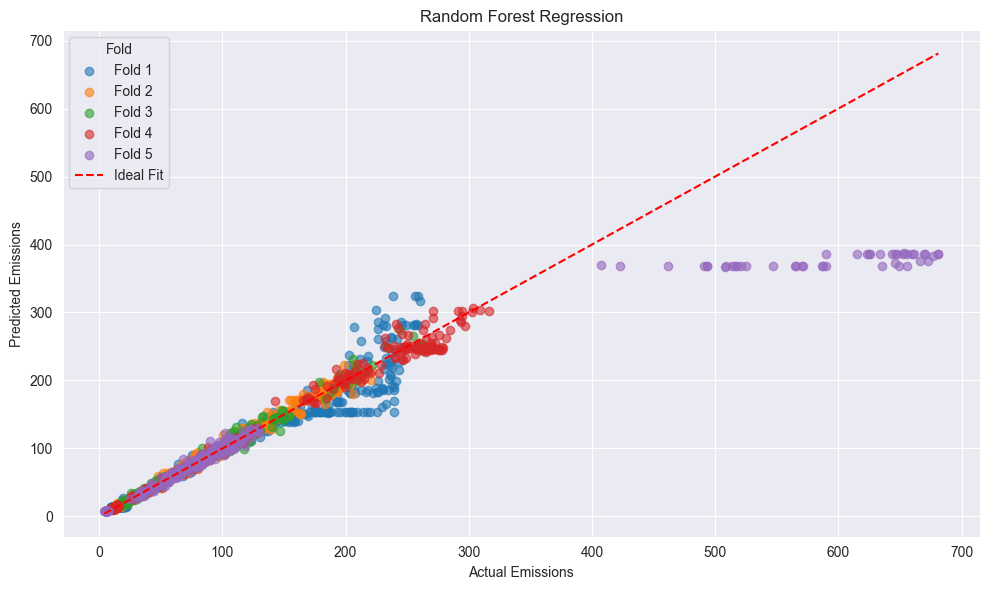


Average R² Score: 0.9383
Average Mean Squared Error: 1353.5360
Average Explained Variance Score: 0.9434

Average Feature Importances Across All Folds:
                   Feature  Mean Importance  Std Deviation
4      emissions_t_minus_1         0.763696       0.259354
0      emissions_t_minus_5         0.060319       0.090163
3      emissions_t_minus_2         0.052615       0.036379
5               population         0.051510       0.086574
2      emissions_t_minus_3         0.034047       0.037038
1      emissions_t_minus_4         0.021736       0.018417
6                     size         0.015768       0.012104
7  party_affiliation_score         0.000309       0.000102

Stratified R² (average across states): -0.2407
Highest R² State: ND (0.9603)
Lowest R² State: VT (-17.1353)


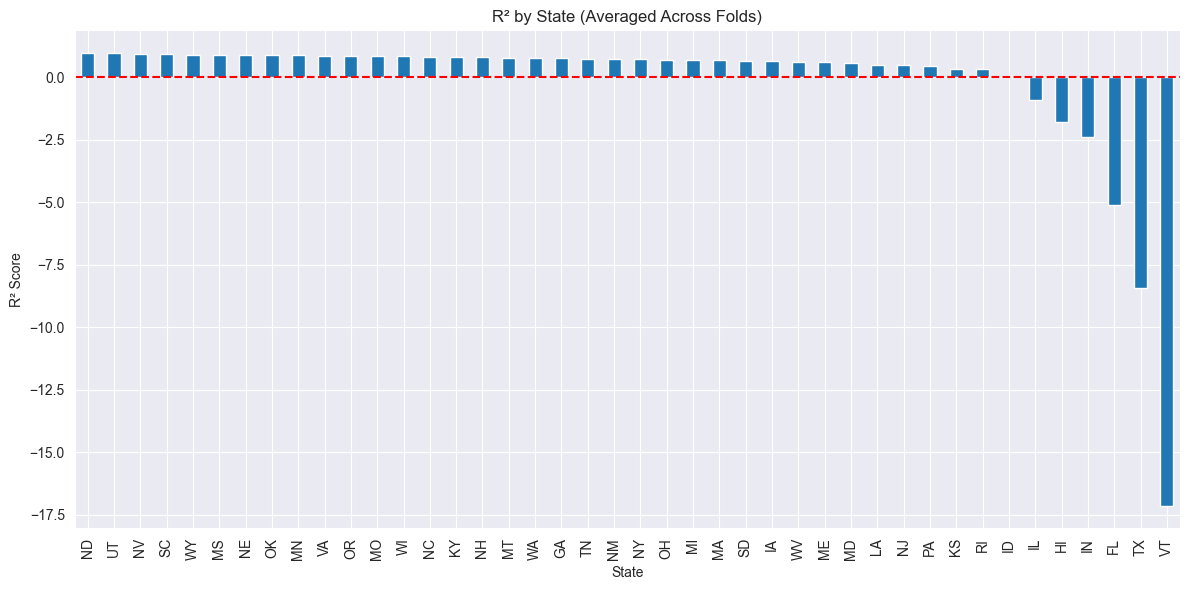


Percentage of folds where 'party_affiliation_score' was the most important feature: 0.00%


([0.9242002696618781,
  0.9888756138317476,
  0.9902636194838037,
  0.9911893865573072,
  0.7970522217379838],
 [485.92148164760044,
  36.18288743192328,
  24.24158613078288,
  80.11681241302325,
  6141.217083081727],
 [0.9276213170983653,
  0.9892626468905026,
  0.9905277699687929,
  0.9913039312690303,
  0.8180606327786373],
                    Feature  Mean Importance  Std Deviation
 4      emissions_t_minus_1         0.763696       0.259354
 0      emissions_t_minus_5         0.060319       0.090163
 3      emissions_t_minus_2         0.052615       0.036379
 5               population         0.051510       0.086574
 2      emissions_t_minus_3         0.034047       0.037038
 1      emissions_t_minus_4         0.021736       0.018417
 6                     size         0.015768       0.012104
 7  party_affiliation_score         0.000309       0.000102,
 -0.24070046614081356,
 ND     0.960286
 UT     0.948839
 NV     0.910451
 SC     0.909223
 WY     0.899421
 MS     0.893018
 NE  

In [50]:
train_random_forest_forecasting(final_df_tmp, window_size=5)